## Setup

In [1]:
import sys
import os
import time
from pathlib import Path
import matplotlib.pyplot as plt
import random
import numpy as np
import pandas as pd
import scipy as sp
import isuelogit as isl
import seaborn as sns
from datetime import datetime

from pesuelogit.visualizations import plot_heatmap_demands
from pesuelogit.models import compute_rr
from pesuelogit.networks import build_tntp_network
from pesuelogit.etl import get_design_tensor, add_period_id

import tensorflow as tf
tf.config.set_visible_devices([], 'GPU')

In [2]:
# Path management
main_dir = str(Path(os.path.abspath('')).parents[1])
os.chdir(main_dir)
print('main dir:', main_dir)

sys.path.append(os.path.join(main_dir, 'src'))

main dir: /Users/pablo/github/nesuelogit


In [3]:
%load_ext autoreload
%autoreload 2

# Internal modules
from nesuelogit.models import ODParameters, UtilityParameters, create_model_tntp, create_bpr, create_mlp_tntp, \
    create_tvodlulpe_model_tntp, create_tvgodlulpe_model_tntp, train_val_split_by_links, train_kfold, compute_generated_trips, \
    compute_generation_factors, compute_benchmark_metrics, create_suelogit
from nesuelogit.visualizations import plot_predictive_performance, plot_metrics_kfold, \
    plot_top_od_flows_periods, plot_utility_parameters_periods, plot_flow_vs_traveltime, plot_performance_functions, \
    plot_annotate_r2, plot_flow_interaction_matrix, plot_parameters_kfold, plot_parameters, plot_convergence_estimates, \
    compute_total_trips_models
from nesuelogit.metrics import mse, mape, r2_score, z2score
from nesuelogit.utils import load_k_shortest_paths

### Hyperparameters and configurations

In [4]:
#Loss function
_LOSS_WEIGHTS = {'od': 0, 'traveltime': 1, 'flow': 1, 'equilibrium': 1}
_LOSS_METRIC = z2score

#Optimization
_BATCH_SIZE = 1
_EPOCHS = {'learning': 60, 'equilibrium': 0}
_LR = {'learning': 5e-2, 'equilibrium': 1e-2}
_OPTIMIZERS = {'learning': tf.keras.optimizers.legacy.Adam(learning_rate=_LR['learning']),
               'equilibrium': tf.keras.optimizers.legacy.Adam(learning_rate=_LR['equilibrium'])
               }
# Equilibrium condition (if different than 'inf', equilibrium 'epochs' must be greater than 0)
_RELATIVE_GAP = float('inf')

## Exogenous features in utility function
_FEATURES_Z = ['tt_sd', 's']

# K-Fold
_N_SPLITS = 5
_POLY_ORDER = 3
_LOSS_WEIGHTS_KFOLD = _LOSS_WEIGHTS.copy()
_EPOCHS_KFOLD = _EPOCHS.copy()

In [5]:
# Seed for reproducibility
_SEED = 2024
np.random.seed(_SEED)
random.seed(_SEED)
tf.random.set_seed(_SEED)

# For report global runtime
t0_global = time.time()

## Build network

In [6]:
network_name = 'SiouxFalls'
network = build_tntp_network(network_name=network_name, folderpath=os.getcwd() + "/input/tntp/")

## Read and load OD matrix

In [7]:
# Load true demand matrix
Q = isl.reader.read_tntp_od(network_name=network_name, folderpath=os.getcwd() + "/input/tntp/")
network.load_OD(Q=Q)

Q_true = [network.OD.Q_true, 0.8*network.OD.Q_true]

# Dense representation of O-D matrix by period
q_true = tf.stack([network.OD.q_true.flatten(), 0.8*network.OD.q_true.flatten()], axis = 0)

Reading Q from external file
Matrix Q (24, 24) read in 0.1[s]                        

360600.0 trips were loaded among 528 o-d pairs


In [8]:
# Add some noise in the the true O-D matrix
Q_historic = [isl.factory.random_disturbance_Q(i.copy(), sd=np.mean(i) * 0.1) for i in Q_true]
q_historic = [isl.networks.denseQ(i.copy()).flatten() for i in Q_historic]

Mean of nonzero entries in the original demand matrix:  683.0
Mean absolute difference between the nonzero entries of the noisy and original: 52.0
Approximated proportion change: 7.6%
Mean of nonzero entries in the original demand matrix:  546.4
Mean absolute difference between the nonzero entries of the noisy and original: 38.6
Approximated proportion change: 7.1%


In [9]:
# Vectors of generated trips by period
generated_trips = compute_generated_trips(q=tf.stack(q_historic), ods=network.ods, n_nodes = len(network.nodes))

generated_trips

<tf.Tensor: shape=(2, 24), dtype=float64, numpy=
array([[ 9009.078 ,  3892.6202,  2921.6413, 11548.0757,  6200.4745,
         7392.1161, 12404.233 , 17029.7714, 16351.1746, 44846.4172,
        21969.2989, 13853.8144, 14276.9753, 13399.2092, 21350.6263,
        26085.6003, 23744.952 ,  4602.0228, 12971.3035, 18735.8556,
        10675.8056, 24328.8651, 14688.4072,  7720.2589],
       [ 7334.2814,  3510.9206,  2046.9991,  9432.0225,  4860.2445,
         6180.1929,  9588.6089, 12953.6178, 13000.4854, 36038.9385,
        18337.1259, 11060.3597, 11704.2975, 11386.6545, 17520.2877,
        20708.6772, 19127.3158,  3867.4954, 10461.9753, 15008.3759,
         8854.5891, 19719.4375, 11353.3008,  6143.9414]])>

## Generate paths

In [10]:
load_k_shortest_paths(network=network, k=3, update_incidence_matrices=True)

1584 paths were loaded and incidence matrices were built


## Read data

In [11]:
# Synthethic data which was generated under the assumption of path sets of size 2.
df = pd.read_csv(
    main_dir + '/input/network-data/' + network.key + '/links/' + network.key + '-link-data.csv')
df

,timepoint,link_key,tt_sd,s,period,traveltime,counts
0,1,"(0, 1, '0')",0.663287,0.608996,0,5.853573,5153.922893
1,1,"(0, 2, '0')",0.218225,0.823825,0,3.854738,5819.684611
2,1,"(1, 0, '0')",0.187173,0.182895,0,5.853705,5241.640666
3,1,"(1, 5, '0')",0.729779,0.786900,0,8.645683,6903.427287
4,1,"(2, 0, '0')",0.863313,0.311387,0,3.854562,5731.982463
...,...,...,...,...,...,...,...
22795,300,"(22, 21, '0')",0.118967,0.941838,2,7.387749,6971.091520
22796,300,"(22, 23, '0')",0.537956,0.516336,2,2.244349,4926.973355
22797,300,"(23, 12, '0')",0.054784,0.694868,2,8.478936,7654.000699
22798,300,"(23, 20, '0')",0.300521,0.431477,2,7.866051,8093.885465


In [12]:
# Generate synthetic node data
node_data = pd.DataFrame({'key': [node.key for node in network.nodes],
                          'income': np.random.rand(len(network.nodes)),
                          'population': np.random.rand(len(network.nodes))
                          })

## Training and validation sets

In [13]:
n_timepoints = len(df.timepoint.unique())
n_links = len(network.links)

# Add free flow travel times
df['tt_ff'] = np.tile([link.bpr.tf for link in network.links], n_timepoints)

In [14]:
period_feature = 'hour'
df = df.rename(columns = {'period': 'hour'})
df = add_period_id(df, period_feature=period_feature)

period_keys = df[[period_feature, 'period_id']].drop_duplicates().reset_index().drop('index', axis=1).sort_values(period_feature)
print(period_keys)

   hour  period_id
0     0          0
1     2          1


In [15]:
X = get_design_tensor(Z=df[_FEATURES_Z + ['period_id']], n_links=n_links, n_timepoints=n_timepoints )
Y = get_design_tensor(y=df[['traveltime', 'counts']], n_links=n_links, n_timepoints=n_timepoints)

# df_T = df[df.hour.isin([0, 5])]
df_T = df
XT = get_design_tensor(Z=df_T[_FEATURES_Z + ['period_id']], n_links=n_links, n_timepoints=n_timepoints )
YT = get_design_tensor(y=df_T[['traveltime', 'counts']], n_links=n_links, n_timepoints=n_timepoints)

In [16]:
_DTYPE = tf.float32

X, XT, Y, YT = [tf.cast(i, _DTYPE) for i in [X, XT, Y, YT]]

Y_train, Y_val = train_val_split_by_links(Y.numpy(), val_size=0)
YT_train, YT_val = train_val_split_by_links(YT.numpy(), val_size=0)

Y_val, YT_val = None, None

X_train, X_val = X, X
X_train, X_val, Y_train, Y_val = [tf.cast(i, _DTYPE) if i is not None else None for i in [X_train, X_val, Y_train, Y_val]]

XT_train, XT_val = XT, XT
XT_train, XT_val, YT_train, YT_val = [tf.cast(i, _DTYPE) if i is not None else None for i in [XT_train, XT_val, YT_train, YT_val]]

In [17]:
n_periods = len(np.unique(XT_train[:, :, -1].numpy().flatten()))

generation_factors = compute_generation_factors(period_column=X[:, :, -1, None].numpy(),
                                                flow_column=Y[:, :, 1, None].numpy(), reference_period=0)

## Models

In [18]:
models = {}
train_results_dfs = {}
val_results_dfs = {}

## a) Equilibrium (SUELOGIT)

In [19]:
print('Gradient based SUELOGIT')

# Note: Here we assume we know the True OD matrix and the scale of the second period is obtained from the link flow data. Otherwise,
# the link flows and travel times obtained at equilibrium will not necessarily match the observed data.

# To report runtime
t0 = time.time()

suelogit, _ = create_suelogit(network = network, n_periods = n_periods,
                              reference_q = generation_factors.values[:, np.newaxis] * network.q.flatten(),
                              features_Z = _FEATURES_Z, dtype = tf.float32)

train_results_dfs['suelogit'], val_results_dfs['suelogit'] = suelogit.compute_equilibrium(
    XT_train,
    node_data=node_data,
    optimizer=_OPTIMIZERS['equilibrium'],
    batch_size=_BATCH_SIZE,
    loss_weights={'equilibrium': 1},
    threshold_relative_gap=1e-5,
    epochs=100)

print(f'\nruntime: {time.time() - t0:0.1f} [s]')

Gradient based SUELOGIT

Computing gradient based equilibrium

Model training

Link flows and travel times were pretrained with single pass of traffic assignment

hyperparameters loss function: {'equilibrium': 1}

number of periods: 2, batch size: 1, threshold relative gap: 1e-05
training set -> timepoints: 300, obs [t x]: nan, coverage [t x]: nan

0/100: train mse=8.4e+07, avg theta = [-1.  -1.3 -3. ], avg rr = 1.30, avg theta fixed effect = 0, loss prop od=0, total trips=[3.61e+05 2.86e+05], avg alpha=0.15, avg beta=4, lambda eq=1, relative gap=0.65, train equilibrium loss=8.4e+07, time: 0.1

1/100: train mse=7.3e+07, avg theta = [-1.  -1.3 -3. ], avg rr = 1.30, avg theta fixed effect = 0, loss prop od=0, total trips=[3.61e+05 2.86e+05], avg alpha=0.15, avg beta=4, lambda eq=1, relative gap=0.59, train equilibrium loss=7.3e+07, time: 5.5

2/100: train mse=6.3e+07, avg theta = [-1.  -1.3 -3. ], avg rr = 1.30, avg theta fixed effect = 0, loss prop od=0, total trips=[3.61e+05 2.86e+05],

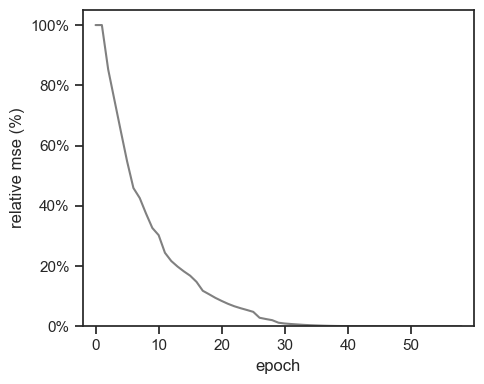

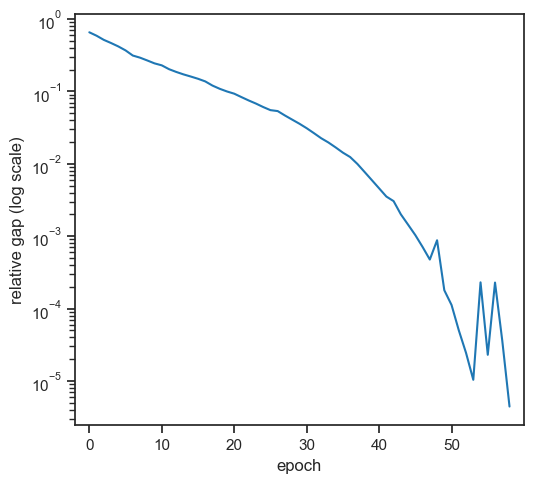

In [20]:
fig, ax = plot_predictive_performance(train_losses=train_results_dfs['suelogit'], val_losses=val_results_dfs['suelogit'],
                            xticks_spacing=10, curves=['equilibrium'])

ax.get_legend().remove()

plt.tight_layout()

plt.savefig('output/figures/experiments/siouxfalls-relative-mse-suelogit.png')

plt.show()

train_results_estimates, train_results_losses = suelogit.split_results(results=train_results_dfs['suelogit'])
val_results_estimates, val_results_losses = suelogit.split_results(results=val_results_dfs['suelogit'])

fig, ax = plot_convergence_estimates(
    estimates=train_results_losses.assign(
        relative_gap=np.abs(train_results_losses['relative_gap']))[['epoch', 'relative_gap']],
    xticks_spacing=10)

ax.set_yscale('log')
ax.set_ylabel('relative gap (log scale)')
ax.get_legend().remove()

plt.savefig('output/figures/experiments/siouxfalls-relative-gap-suelogit.png')

plt.show()

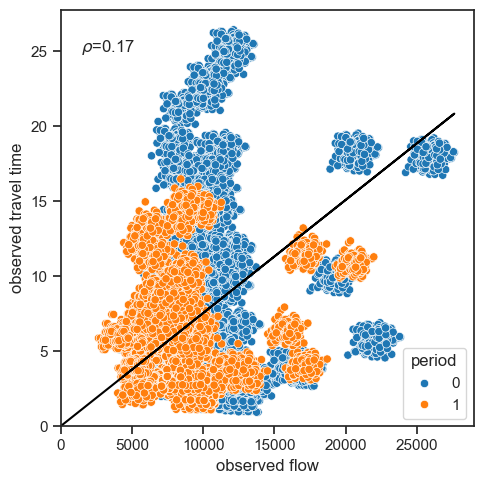

In [21]:
fig, ax = plot_flow_vs_traveltime(model = suelogit,
                        observed_traveltime=Y[:, :, 0],
                        observed_flow= Y[:,:,1],
                        period_col = X[:,:,-1].numpy().astype(int).flatten(),
                        # scatter_kws={"color": sns.color_palette("deep")[0], 's':4, 'alpha': 1}, line_kws={"color": "black"},
                        all_metrics = False,
                        only_observed = True,
                        ampm_format = False
                        )

ax.legend(loc='lower right', title = 'period')

ax.set_xlim(xmin=-1e-2)
ax.set_ylim(ymin=-1e-2)

plt.savefig('output/figures/experiments/siouxfalls-scatter-flow-traveltime.png')

plt.show()

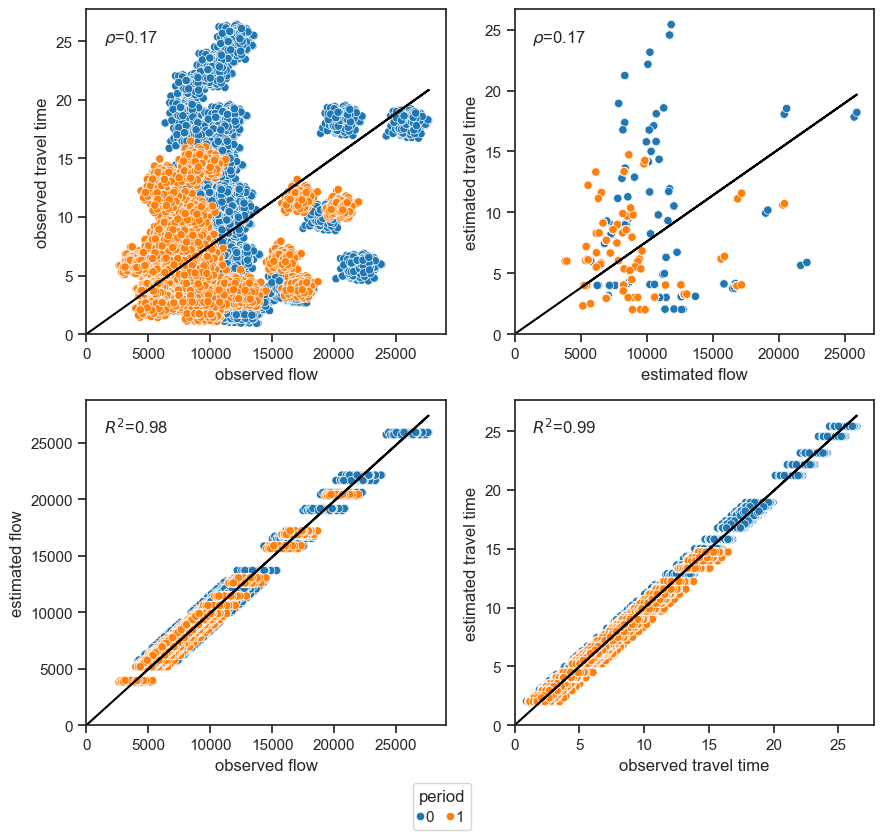

In [22]:
fig, axs = plot_flow_vs_traveltime(model = suelogit,
                        observed_traveltime=Y[:, :, 0],
                        observed_flow= Y[:,:,1],
                        period_col = X[:,:,-1].numpy().astype(int).flatten(),
                        # scatter_kws={"color": sns.color_palette("deep")[0], 's':4, 'alpha': 1}, line_kws={"color": "black"},
                        all_metrics = False,
                        ampm_format = False
                        )

for ax in axs.reshape(-1):
    ax.set_xlim(xmin=-1e-2)
    ax.set_ylim(ymin=-1e-2)

# axs[1,1].set_xlim(xmin=-1)

plt.savefig('output/figures/experiments/siouxfalls-scatter-flow-traveltime-suelogit.png')

plt.show()

## b) Benchmark (TVODLULPE)

In [23]:

print('\ntvodlulpe: Time specific utility and OD, link performance parameters')

t0 = time.time()

models['tvodlulpe'] = create_tvodlulpe_model_tntp(network = network, n_periods = n_periods,
                                                  reference_q = q_historic, features_Z=_FEATURES_Z)

train_results_dfs['tvodlulpe'], val_results_dfs['tvodlulpe'] = models['tvodlulpe'].fit(
    XT_train, YT_train, XT_val, YT_val,
    optimizers= _OPTIMIZERS,
    node_data=node_data,
    batch_size=_BATCH_SIZE,
    loss_weights=_LOSS_WEIGHTS,
    loss_metric= _LOSS_METRIC,
    threshold_relative_gap=_RELATIVE_GAP,
    epochs=_EPOCHS)

print(f'\nruntime: {time.time() - t0:0.1f} [s]')

models['tvodlulpe'].save_weights(models['tvodlulpe']._filepath_weights)


tvodlulpe: Time specific utility and OD, link performance parameters

Model training

Link flows and travel times were pretrained with single pass of traffic assignment

hyperparameters loss function: {'od': 0, 'traveltime': 1, 'flow': 1, 'equilibrium': 1}

number of periods: 2, batch size: 1, threshold relative gap: inf
training set -> timepoints: 300, obs [t x]: [76. 76.], coverage [t x]: [1. 1.]
validation set -> timepoints: 300, obs [t x]: nan, coverage [t x]: nan

Learning stage: 60 epochs

0/60: train mse=1.6e+07, train mse traveltime=27, train mape traveltime=44.0 train mse flow=8e+06, train mape flow=17.8, avg theta = [-1. -1. -1.], avg rr = 1.00, avg theta fixed effect = 0, loss prop od=2.9e-09, total trips=[3.60e+05 2.90e+05], avg alpha=1, avg beta=1, lambda eq=1, relative gap=0.38, train equilibrium loss=4e+07, time: 0.1

1/60: train mse=2.1e+06, train mse traveltime=1.7, train mape traveltime=11.9 train mse flow=3.5e+06, train mape flow=12.4, avg theta = [-0.279 -1.644 -1.

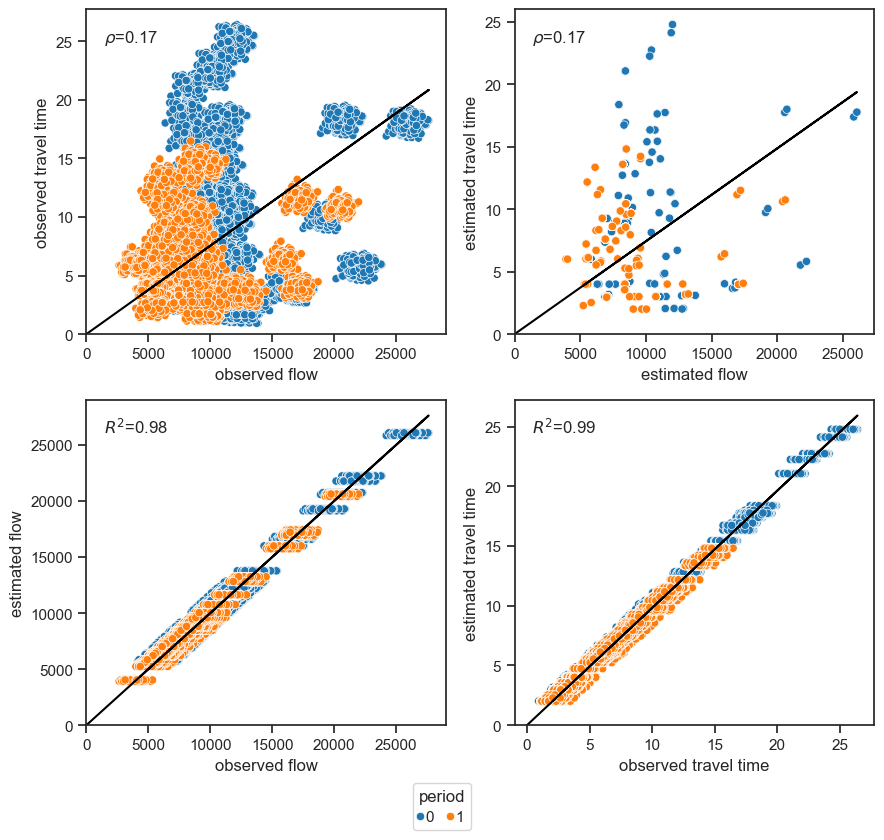

In [24]:
fig, axs = plot_flow_vs_traveltime(model = models['tvodlulpe'],
                                   observed_traveltime=Y[:, :, 0],
                                   observed_flow= Y[:,:,1],
                                   period_col = X[:,:,-1].numpy().astype(int).flatten(),
                                   # scatter_kws={"color": sns.color_palette("deep")[0], 's':4, 'alpha': 1}, line_kws={"color": "black"},
                                   all_metrics = False,
                                   ampm_format = False
                                   )

for ax in axs.reshape(-1):
    ax.set_xlim(xmin=-1e-2)
    ax.set_ylim(ymin=-1e-2)

axs[1,1].set_xlim(xmin=-1)

plt.savefig('output/figures/experiments/siouxfalls-scatter-flow-traveltime-tvodlulpe.png')

plt.show()

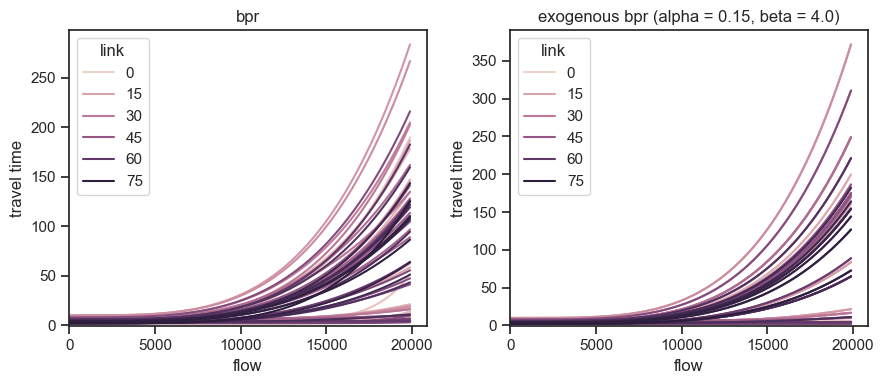

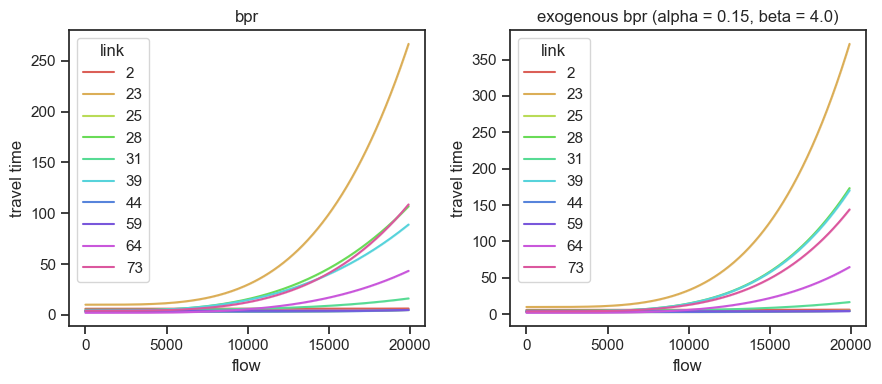

In [25]:
flow_range = range(0, 20000, 100)
sharey = False

fig, axs = plot_performance_functions(model = models['tvodlulpe'],
                                      network = network,
                                      marginal = False,
                                      alpha=0.15*np.ones(network.get_n_links()),
                                      beta=4*np.ones(network.get_n_links()),
                                      sharey = sharey,
                                      flow_range = flow_range
                                      # selected_links = np.random.choice(range(network.get_n_links()), 10, replace=False)
                                      )

for ax in axs.reshape(-1):
    ax.set_xlim(xmin=-10)
    ax.set_ylim(ymin=-1)
    ax.legend(loc='upper left', title = 'link')

plt.savefig('output/figures/experiments/siouxfalls-comparison-all-link-performance-functions-tvodlulpe.png')

plt.show()

selected_links = np.random.choice(range(network.get_n_links()), 10, replace=False)

plot_performance_functions(model=models['tvodlulpe'],
                           network=network,
                           marginal=True,
                           alpha=0.15*np.ones(network.get_n_links()),
                           beta=4*np.ones(network.get_n_links()),
                           selected_links = selected_links,
                           palette = sns.color_palette("hls", len(selected_links)),
                           sharey = sharey,
                           flow_range = flow_range
                           )

plt.show()


(<Figure size 500x400 with 1 Axes>, <Axes: xlabel='epoch', ylabel='mape'>)

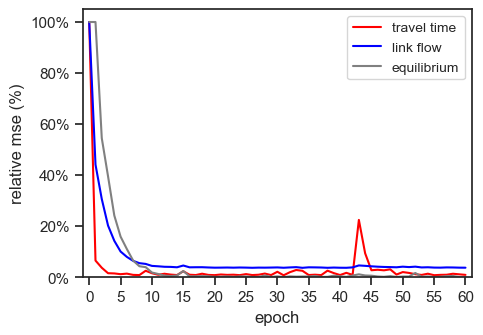

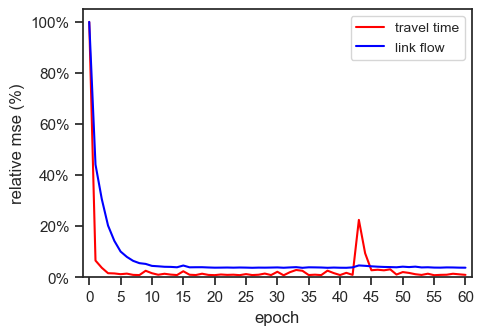

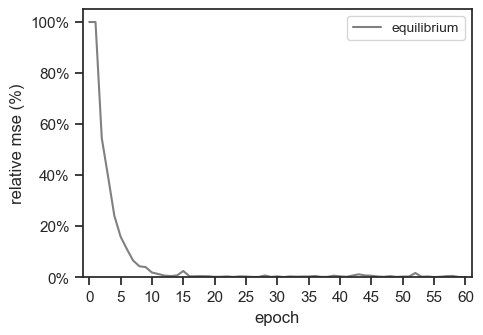

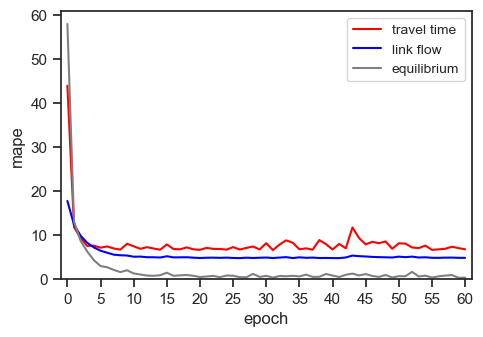

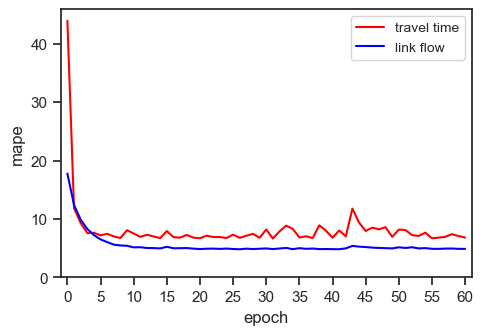

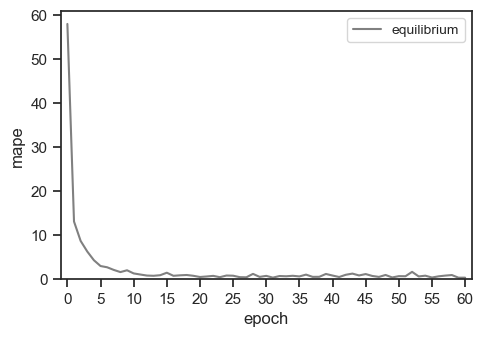

In [26]:
plot_predictive_performance(train_losses=train_results_dfs['tvodlulpe'],
                            val_losses=val_results_dfs['tvodlulpe'],
                            # curves = ['link flow', 'travel time'],
                            xticks_spacing=5, show_validation=False,
                            epochs_end_learning_stage=_EPOCHS['learning'])

plot_predictive_performance(train_losses=train_results_dfs['tvodlulpe'],
                            val_losses=val_results_dfs['tvodlulpe'],
                            curves = ['link flow', 'travel time'],
                            xticks_spacing=5, show_validation=False,
                            epochs_end_learning_stage=_EPOCHS['learning'])

plt.savefig('output/figures/experiments/siouxfalls-relative-mse-tvodlulpe.png')

plot_predictive_performance(train_losses=train_results_dfs['tvodlulpe'],
                            val_losses=val_results_dfs['tvodlulpe'],
                            curves = ['equilibrium'],
                            xticks_spacing=5, show_validation=False,
                            epochs_end_learning_stage=_EPOCHS['learning'])

plot_predictive_performance(train_losses=train_results_dfs['tvodlulpe'],
                            val_losses=val_results_dfs['tvodlulpe'],
                            xticks_spacing=5, show_validation=False,
                            # curves = ['link flow', 'travel time'],
                            epochs_end_learning_stage=_EPOCHS['learning'], prefix_metric='mape',
                            yaxis_label='mape')

plot_predictive_performance(train_losses=train_results_dfs['tvodlulpe'],
                            val_losses=val_results_dfs['tvodlulpe'],
                            xticks_spacing=5, show_validation=False,
                            curves = ['link flow', 'travel time'],
                            epochs_end_learning_stage=_EPOCHS['learning'], prefix_metric='mape',
                            yaxis_label='mape')

plt.savefig('output/figures/experiments/siouxfalls-mape-tvodlulpe.png')

plot_predictive_performance(train_losses=train_results_dfs['tvodlulpe'],
                            val_losses=val_results_dfs['tvodlulpe'],
                            xticks_spacing=5, show_validation=False,
                            curves = ['equilibrium'],
                            epochs_end_learning_stage=_EPOCHS['learning'], prefix_metric='mape',
                            yaxis_label='mape')

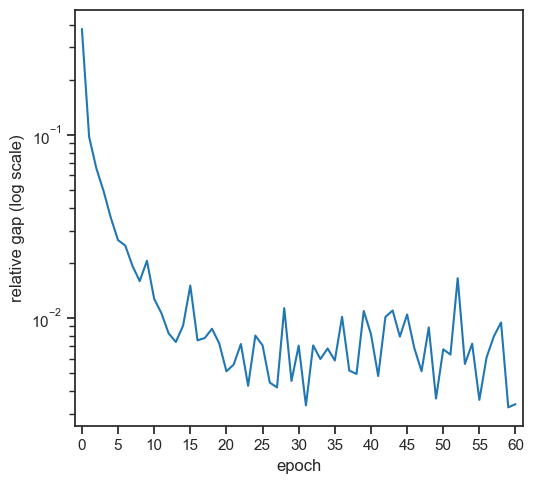

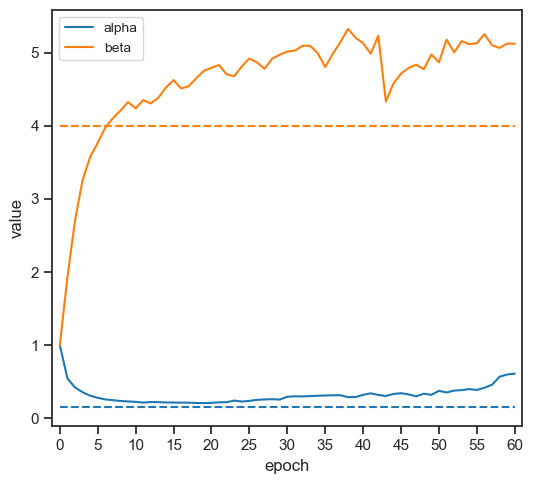

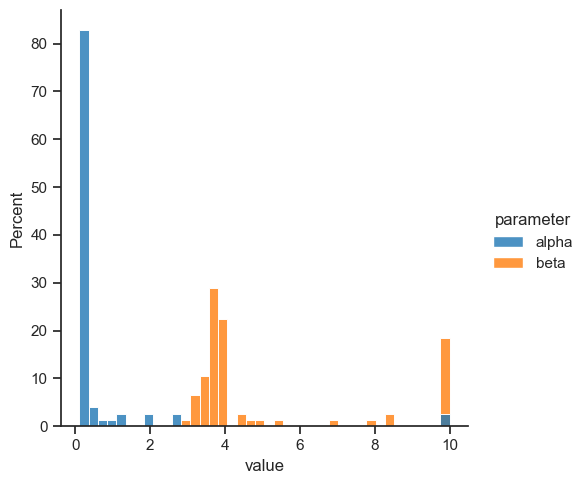

parameter
alpha    0.610632
beta     5.120781
Name: value, dtype: float32


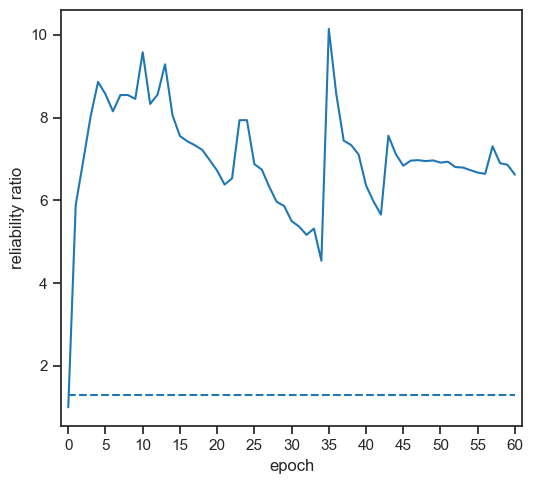

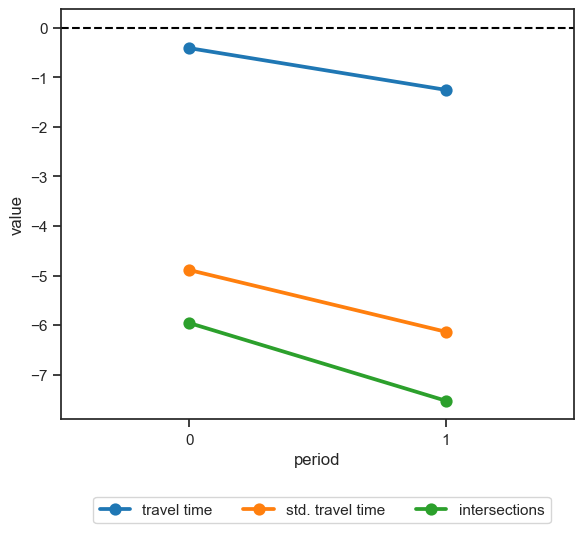

   period         parameter     value    group
0       0       travel time -0.411912  utility
1       1       travel time -1.253874  utility
2       0  std. travel time -4.889733  utility
3       1  std. travel time -6.135035  utility
4       0     intersections -5.958877  utility
5       1     intersections -7.526962  utility


In [27]:
fig, ax = plot_convergence_estimates(
    estimates=train_results_dfs['tvodlulpe'].assign(
        relative_gap=np.abs(train_results_dfs['tvodlulpe']['relative_gap']))[['epoch', 'relative_gap']],
    xticks_spacing=5)

ax.set_yscale('log')
ax.set_ylabel('relative gap (log scale)')
ax.get_legend().remove()

plt.savefig('output/figures/experiments/siouxfalls-relative-gap-tvodlulpe.png')

plt.show()


plot_convergence_estimates(estimates=train_results_dfs['tvodlulpe'][['epoch', 'alpha', 'beta']],
                           xticks_spacing=5,
                           true_values=models['tvodlulpe'].performance_function.parameters.true_values,
                           )

plt.show()
plot_data = pd.melt(pd.DataFrame({'alpha': models['tvodlulpe'].performance_function.alpha,
                                  'beta': models['tvodlulpe'].performance_function.beta}), var_name='parameter')

#sns.displot(plot_data, x="value", hue="parameter", multiple="stack", kind="hist", alpha=0.8, norm_hist=True)

# fig, ax = plt.subplots(nrows=1, ncols=1, figsize = (5,4))
# sns.histplot(plot_data, x="value", stat='density', hue="parameter", ax = ax)

# sns.displot(plot_data, x="value", col="parameter", kind="hist", hue = "parameter", alpha=0.8, facet_kws=dict(sharey=False, sharex = False), binwidth = 0.25)
try:
    sns.displot(plot_data, x="value", kind="hist", stat='percent', common_norm=False, hue = "parameter", alpha=0.8, facet_kws=dict(sharey=False, sharex = False), binwidth = 0.25)
    plt.savefig('output/figures/experiments/siouxfalls-distribution-link-performance-parameters-tvodlulpe.png')
    plt.show()
except:
    print('Distribution plot could not be shown')

print(plot_data.groupby('parameter')['value'].mean())

fig, ax = plot_convergence_estimates(estimates=train_results_dfs['tvodlulpe']. \
                           assign(rr=train_results_dfs['tvodlulpe']['tt_sd'] / train_results_dfs['tvodlulpe']['tt'])[['epoch', 'rr']],
                           true_values={'rr': models['tvodlulpe'].utility.true_values['tt_sd']/models['tvodlulpe'].utility.true_values['tt']},
                           xticks_spacing=5)
# ax.legend(loc = 'lower right')
ax.get_legend().remove()
ax.set_ylabel("reliability ratio")
plt.show()

# Utility by period

theta_df = plot_utility_parameters_periods(models['tvodlulpe'], period_keys=period_keys, period_feature='hour', plot = False).reset_index().drop(['hour','index'], axis = 1).reset_index().rename(columns = {'index':'period'})

# theta_df = pd.melt(theta_df.assign(rr = theta_df.apply(compute_rr, axis=1)), id_vars = 'period', var_name = 'parameter').assign(group = 'utility').replace({'tt': 'travel time', 'tt_sd': 'std. travel time', 's': 'intersections', 'rr': 'reliability ratio'})

theta_df = pd.melt(theta_df, id_vars = 'period', var_name = 'parameter').assign(group = 'utility').replace({'tt': 'travel time', 'tt_sd': 'std. travel time', 's': 'intersections'})

fig, ax = plot_parameters(df = theta_df, n_cols_legend = 3, figsize = (6,5.5))

plt.axhline(0, linestyle ='dashed', color = 'black')

plt.savefig(f'output/figures/experiments/siouxfalls-utility-periods-tvodlulpe.png')

plt.show()

print(theta_df)

# Compute utility parameters over time (heatmap) and value of travel time reliability (lineplot)
# theta_df = plot_utility_parameters_periods(models['tvodlulpe'], period_keys=period_keys, period_feature='hour', plot = False)
#
# rr_df = theta_df.apply(compute_rr, axis=1).reset_index().rename(columns={'index': period_feature, 0: 'rr'})
#
# sns.lineplot(data=rr_df, x=period_feature, y="rr")
#
# plt.show()

/Users/pablo/github/nesuelogit/src/nesuelogit/visualizations.py:879: UserWarning: 

The `join` parameter is deprecated and will be removed in v0.15.0. You can remove the line between points with `linestyle='none'`.

  g = sns.pointplot(data=total_trips_by_hour, x=period_feature, y='total_trips', ax=ax,


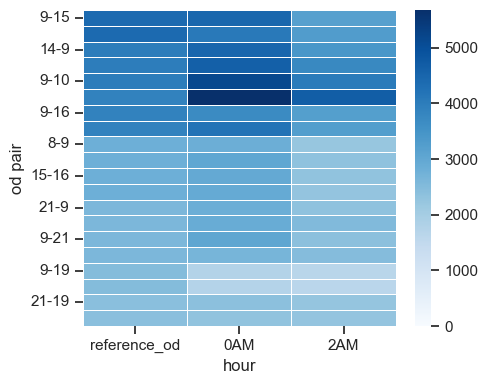

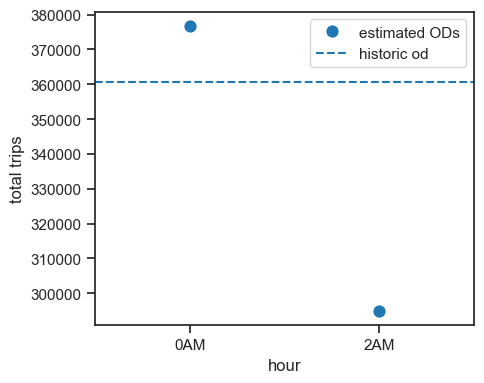

period 0

correlation: 0.9588112278167171


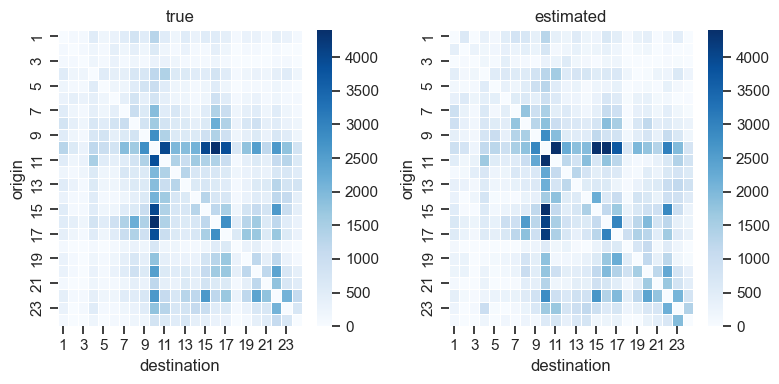

period 1

correlation: 0.9698393108777597


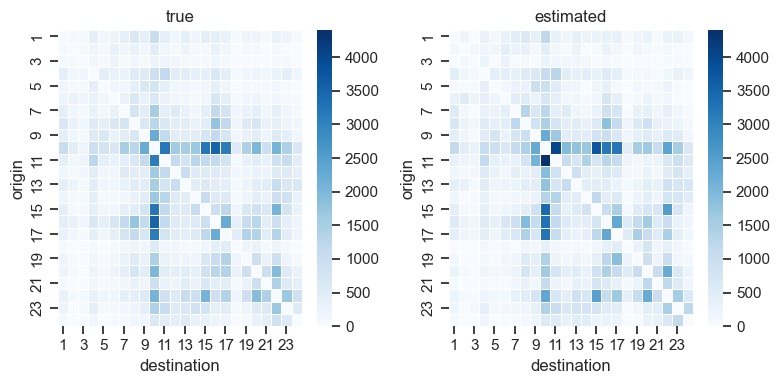

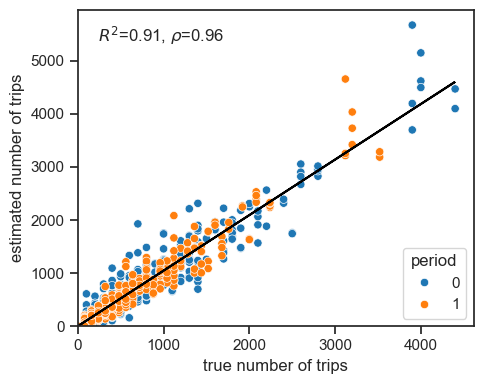

In [28]:
# Plot heatmap with flows of top od pairs
_ = plot_top_od_flows_periods(models['tvodlulpe'], period_keys=period_keys, period_feature=period_feature, top_k=20,
                          reference_od=network.q.flatten())

plt.show()

# Plot heatmaps with OD matrix

estimated_Q = models['tvodlulpe'].Q.numpy()
plot_data = pd.DataFrame()

for period in range(estimated_Q.shape[0]):
    print(f'period {period}\n')
    Qs = {'true': Q_true[period], 'estimated': estimated_Q[period]}  # 'historic': Q_historic,

    rho_val, p = sp.stats.pearsonr(Qs["true"].flatten(), Qs["estimated"].flatten())
    print(f'correlation: {rho_val}')

    plot_heatmap_demands(Qs=Qs, vmin=np.min(Q_true[0]), vmax=np.max(Q_true[0]), subplots_dims=(1, len(Qs.keys())),
                         figsize=(4*len(Qs.keys()), 4))
    plt.show()

    plot_data = pd.concat([plot_data, pd.DataFrame({'true': Qs['true'].flatten(), 'estimated':Qs['estimated'].flatten(),
                                                    'period': period})])

fig, ax = plt.subplots(1, 1, figsize=(5, 4), tight_layout=True)
sns.scatterplot(data=plot_data, x='true', y='estimated', hue = 'period', ax = ax)
plot_annotate_r2(ax=ax, x=plot_data['true'], y=plot_data['estimated'], intercept = False, r2 = True, rho = True)
ax.set_xlabel('true number of trips')
ax.set_ylabel('estimated number of trips')
ax.legend(loc='lower right', title = 'period')
ax.set_xlim(xmin=-1e-2)
ax.set_ylim(ymin=-1e-2)

plt.savefig(f'output/figures/experiments/siouxfalls-scatter-ode-tvodlulpe.png')

plt.show()

In [29]:
print(f"theta = "
      f"{dict(zip(models['tvodlulpe'].utility.true_values.keys(), list(np.mean(models['tvodlulpe'].theta.numpy(), axis=0))))}")

if models['tvodlulpe'].performance_function.type == 'bpr':
    print(f"alpha = {np.mean(models['tvodlulpe'].performance_function.alpha): 0.2f}, "
          f"beta  = {np.mean(models['tvodlulpe'].performance_function.beta): 0.2f}")

print(f"Avg abs diff of observed and estimated OD: "
      f"{np.mean(np.abs(models['tvodlulpe'].q - network.q.flatten())): 0.2f}")

print(f"Avg observed OD: {np.mean(np.abs(network.q.flatten())): 0.2f}")

theta = {'tt': -0.8328929, 'tt_sd': -5.5123835, 's': -6.7429194}
alpha =  0.61, beta  =  5.12
Avg abs diff of observed and estimated OD:  150.03
Avg observed OD:  682.95


In [30]:
metrics_df = models['tvodlulpe'].compute_loss_metrics(metrics={'mape': mape, 'mse': mse, 'r2': r2_score},
                                                      X=XT_train, Y=YT_train).assign(dataset='training')

if YT_val is not None:
    metrics_df = pd.concat([metrics_df,
                            models['tvodlulpe'].compute_loss_metrics(metrics={'mape': mape, 'mse': mse, 'r2': r2_score},
                                                                     X=XT_val, Y=YT_val).assign(dataset='validation'),
                            compute_benchmark_metrics(metrics={'mape': mape, 'mse': mse, 'r2': r2_score}, Y_ref=YT_train,
                                                      Y=YT_val).assign(
                                dataset='benchmark')
                            ])

with pd.option_context('display.float_format', '{:0.2g}'.format):
    print(pd.pivot(metrics_df, index=['component', 'dataset'], columns=['metric'])['value'])

metric                mape     mse   r2
component   dataset                    
equilibrium training  0.36 1.9e+03    1
flow        training   4.9   3e+05 0.98
traveltime  training   6.8    0.25 0.99


## c) TVGODLULPE

In [31]:
print('\ntvgodlulpe: Time varying route choice utility and trip generation, and link specific parameters for performance functions')

t0 = time.time()

models['tvgodlulpe'] = create_tvgodlulpe_model_tntp(network = network, n_periods=n_periods,
                                                    reference_g = generated_trips, features_Z=_FEATURES_Z)

train_results_dfs['tvgodlulpe'], val_results_dfs['tvgodlulpe'] = models['tvgodlulpe'].fit(
    XT_train, YT_train, XT_val, YT_val,
    optimizers= _OPTIMIZERS,
    node_data=node_data,
    batch_size=_BATCH_SIZE,
    loss_weights=_LOSS_WEIGHTS,
    loss_metric= _LOSS_METRIC,
    threshold_relative_gap=_RELATIVE_GAP,
    epochs=_EPOCHS
)

print(f'\nruntime: {time.time() - t0:0.1f} [s]')

models['tvgodlulpe'].save_weights(models['tvgodlulpe']._filepath_weights)


tvgodlulpe: Time varying route choice utility and trip generation, and link specific parameters for performance functions

Model training

Link flows and travel times were pretrained with single pass of traffic assignment

hyperparameters loss function: {'od': 0, 'traveltime': 1, 'flow': 1, 'equilibrium': 1.0}

number of periods: 2, batch size: 1, threshold relative gap: inf
training set -> timepoints: 300, obs [t x]: [76. 76.], coverage [t x]: [1. 1.]
validation set -> timepoints: 300, obs [t x]: nan, coverage [t x]: nan

Learning stage: 60 epochs

0/60: train mse=7.8e+07, train mse traveltime=6e+04, train mape traveltime=1071.2 train mse flow=9.5e+07, train mape flow=69.1, avg theta = [-1. -1. -1.], avg rr = 1.00, avg theta fixed effect = 0, loss prop od=0, total trips=[3.60e+05 2.90e+05], polynomial weights: [1.0e+00 1.0e+00 1.0e+00], lambda eq=1, relative gap=0.63, train equilibrium loss=1.4e+08, time: 0.1

1/60: train mse=3.4e+07, train mse traveltime=77, train mape traveltime=55

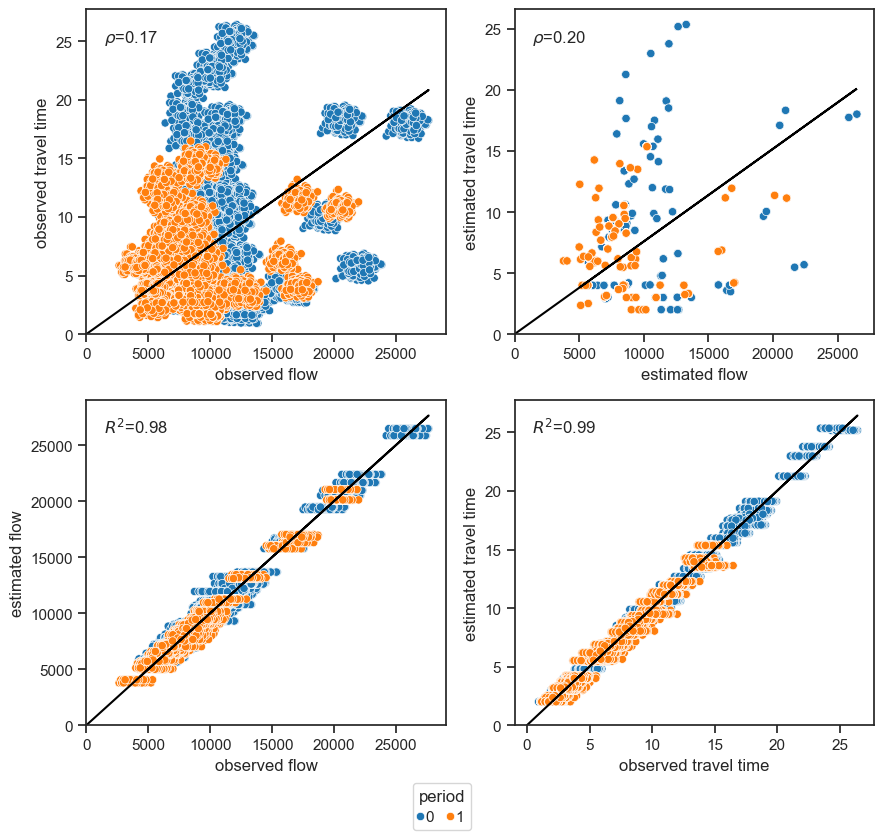

In [32]:
fig, axs = plot_flow_vs_traveltime(model = models['tvgodlulpe'],
                        observed_traveltime=Y[:, :, 0],
                        observed_flow= Y[:,:,1],
                        period_col = X[:,:,-1].numpy().astype(int).flatten(),
                        # scatter_kws={"color": sns.color_palette("deep")[0], 's':4, 'alpha': 1}, line_kws={"color": "black"},
                        all_metrics = False,
                        ampm_format = False
                        )
for ax in axs.reshape(-1):
    ax.set_xlim(xmin=-1e-2)
    ax.set_ylim(ymin=-1e-2)

axs[1,1].set_xlim(xmin=-1)

plt.savefig('output/figures/experiments/siouxfalls-scatter-flow-traveltime-tvgodlulpe.png')

plt.show()

In [33]:
flow_range = range(0, 20000, 100)
sharey = False

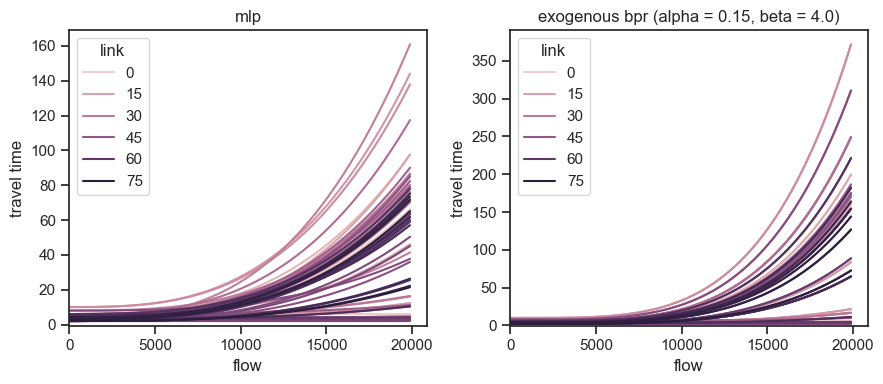

In [34]:
fig, axs = plot_performance_functions(model = models['tvgodlulpe'],
                                      network = network,
                                      marginal = False,
                                      alpha=0.15*np.ones(network.get_n_links()),
                                      beta=4*np.ones(network.get_n_links()),
                                      sharey = sharey,
                                      flow_range = flow_range
                                      )

for ax in axs.reshape(-1):
    ax.set_xlim(xmin=-10)
    ax.set_ylim(ymin=-1)
    ax.legend(loc='upper left', title = 'link')

plt.savefig('output/figures/experiments/siouxfalls-comparison-all-link-performance-functions-tvgodlulpe.png')

plt.show()

# plot_performance_functions(model = models['tvgodlulpe'],
#                                network = network,
#                                marginal = True,
#                                alpha=models['tvgodlulpe'].performance_function.polynomial_layer.alpha_prior*np.ones(network.get_n_links()),
#                                beta=models['tvgodlulpe'].performance_function.polynomial_layer.beta_prior*np.ones(network.get_n_links()),
#                                # alpha=0.15*np.ones(network.get_n_links()),
#                                # beta=4*np.ones(network.get_n_links()),
#                                sharey = sharey,
#                                flow_range = flow_range
#                                # selected_links = np.random.choice(range(network.get_n_links()), 10, replace=False)
#                                )
#
# plt.show()

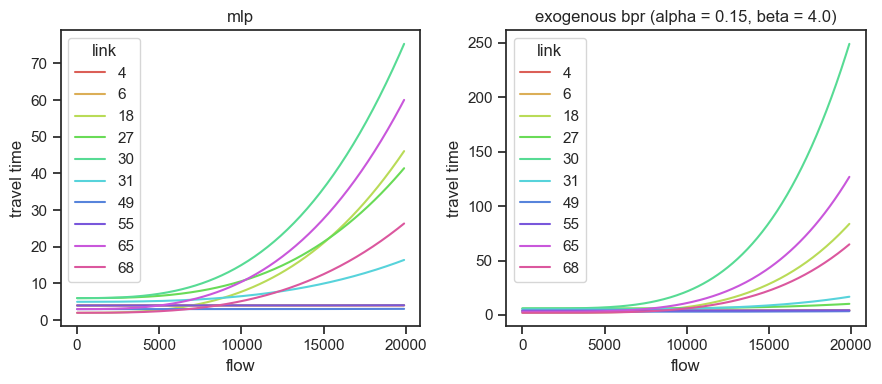

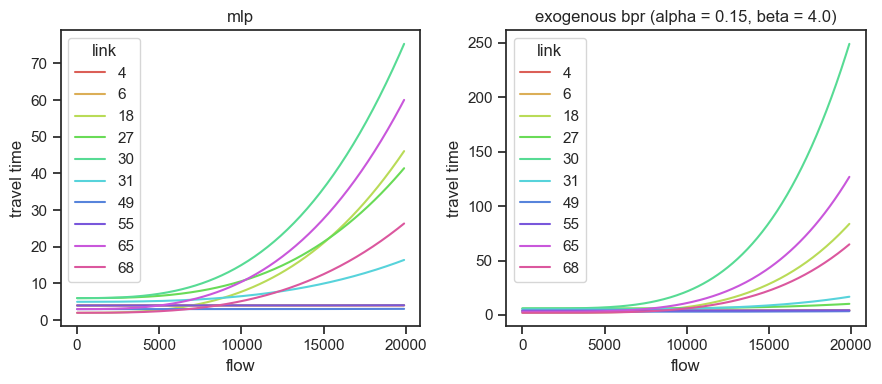

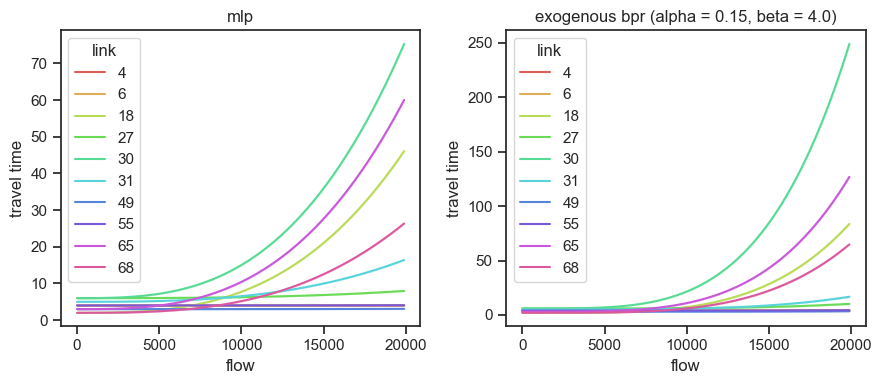

In [35]:
selected_links = np.random.choice(range(network.get_n_links()), 10, replace=False)

# Plot with bpr used the priors of the BPR parameters used to pretrain the MLP

plot_performance_functions(model=models['tvgodlulpe'],
                           network=network,
                           marginal=False,
                           alpha=0.15*np.ones(network.get_n_links()),
                           beta=4*np.ones(network.get_n_links()),
                           selected_links = selected_links,
                           palette = sns.color_palette("hls", len(selected_links)),
                           sharey = sharey,
                           flow_range = flow_range
                           )

plt.show()

plot_performance_functions(model=models['tvgodlulpe'],
                           network=network,
                           marginal=False,
                           alpha=0.15*np.ones(network.get_n_links()),
                           beta=4*np.ones(network.get_n_links()),
                           selected_links = selected_links,
                           palette = sns.color_palette("hls", len(selected_links)),
                           sharey = sharey,
                           flow_range = flow_range
                           )

plt.show()

# Marginal increases show that function are still monotonically increasing
plot_performance_functions(model=models['tvgodlulpe'],
                           network=network,
                           marginal=True,
                           alpha=0.15*np.ones(network.get_n_links()),
                           beta=4*np.ones(network.get_n_links()),
                           selected_links = selected_links,
                           palette = sns.color_palette("hls", len(selected_links)),
                           sharey = sharey,
                           flow_range = flow_range
                           )

plt.show()

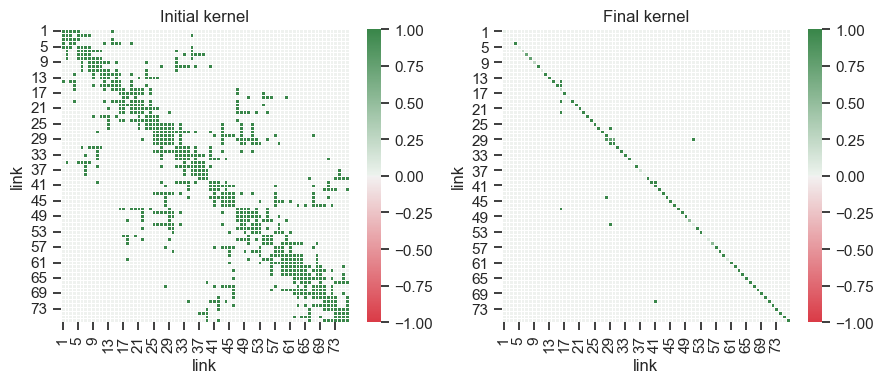

Final weights:
 [[0.0387 0.     0.     ... 0.     0.     0.    ]
 [0.     0.0014 0.     ... 0.     0.     0.    ]
 [0.     0.     0.0112 ... 0.     0.     0.    ]
 ...
 [0.     0.     0.     ... 6.4395 0.     0.    ]
 [0.     0.     0.     ... 0.     6.9952 0.    ]
 [0.     0.     0.     ... 0.     0.     3.6779]]

Initial weights:
 [[1. 1. 1. ... 0. 0. 0.]
 [1. 1. 1. ... 0. 0. 0.]
 [1. 1. 1. ... 0. 0. 0.]
 ...
 [0. 0. 0. ... 1. 1. 1.]
 [0. 0. 0. ... 1. 1. 1.]
 [0. 0. 0. ... 1. 1. 1.]]


In [36]:
# Experiments assume no link flow interactions and that all parameters mapping flow to travel time have the same value.
# With this approach, the parameter becomes almost equal to alpha = 0.15.
# weights = models['tvgodlulpe'].performance_function.weights[1].numpy()
if models['tvgodlulpe'].performance_function.kernel_constraint.homogenous:
    weights_interaction = models['tvgodlulpe'].performance_function.model.layers[0].parameter.numpy()
else:
    # weights_interaction = models['tvgodlulpe'].performance_function.weights[-1].numpy()
    weights_interaction = models['tvgodlulpe'].performance_function.model.layers[0].kernel_matrix.numpy()

initial_weights = models['tvgodlulpe'].performance_function.kernel_constraint.initial_values.numpy()

plot_flow_interaction_matrix(
    flow_interaction_matrix=weights_interaction,
    masking_matrix = initial_weights,
    #flow_interaction_matrix= np.where(weights_interaction>0, 1, -1)*np.where(weights_interaction==0, 0, 1),
    #masking_matrix = np.where(initial_weights>0, 1, -1)*np.where(initial_weights==0, 0, 1),
    # vmin = -0.2, vmax = 0.2
    vmin = -1, vmax = 1
)
plt.savefig('output/figures/experiments/siouxfalls-kernel-link-performance-functions-tvgodlulpe.png')

plt.show()

print(f'Final weights:\n {weights_interaction}')
print(f'\nInitial weights:\n',initial_weights)

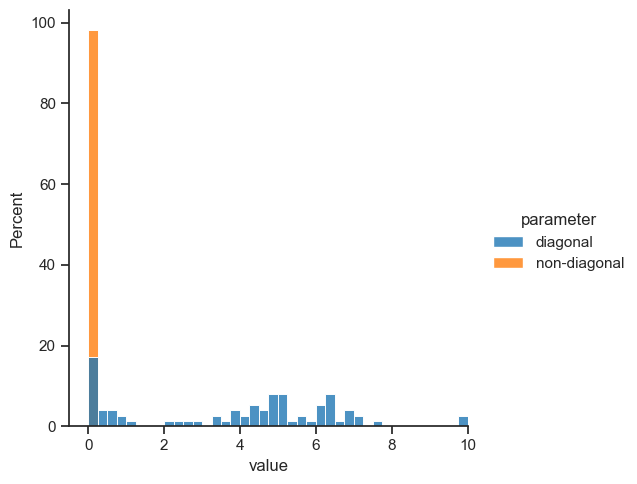

                 value  value_abs
parameter                        
diagonal      3.847097   3.847097
non-diagonal  0.060939   0.060939
              value
parameter          
diagonal         76
non-diagonal    788


In [37]:
# Distribution of weight in interaction flow matrix. Elements that are set to zero by default are excluded from non-diagonal
plot_data = pd.concat([pd.DataFrame({'value': tf.linalg.diag_part(weights_interaction).numpy().flatten(), 'parameter': 'diagonal'}),
                                  pd.DataFrame({'value': weights_interaction[np.where(~np.eye(weights_interaction.shape[0],dtype=bool)*models['tvgodlulpe'].performance_function.kernel_constraint.adjacency_constraint_matrix)], 'parameter': 'non-diagonal'})])

plot_data['value_abs'] = plot_data.value.abs()

# sns.displot(data = plot_data, x="value", col="type", kind="hist", hue = "type", alpha=0.8, facet_kws=dict(sharey=False, sharex = False))
# plt.show()

# fig, ax = plt.subplots(nrows=1, ncols=1, figsize = (5,4))
# sns.histplot(plot_data, x="value", stat='density', hue="parameter", alpha = 0.8, multiple="stack", ax = ax)
try:
    sns.displot(data = plot_data, x="value", kind="hist", stat='percent', common_norm=False, hue = "parameter", alpha=0.8,
                facet_kws=dict(sharey=False, sharex = False), binwidth = 0.25)
    plt.xlim(-0.5, 10)
    plt.savefig('output/figures/experiments/siouxfalls-distribution-link-performance-parameters-tvgodlulpe.png')
    plt.show()
except:
    print('Distribution plot could not be shown')
print(plot_data.groupby('parameter')[['value', 'value_abs']].mean())
print(plot_data.groupby('parameter')[['value']].count())

In [38]:
# Weight of polynomial
print(f"polynomial weights {tf.reduce_mean(models['tvgodlulpe'].performance_function.polynomial_layer.poly_weights,0).numpy()}")

polynomial weights [0.0006 0.0044 0.0427]


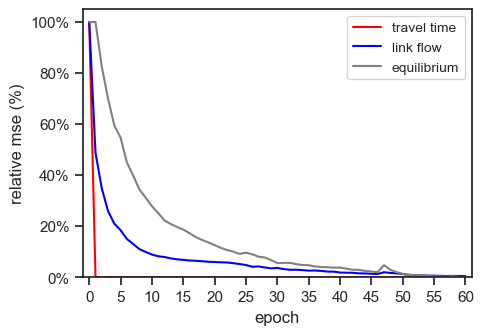

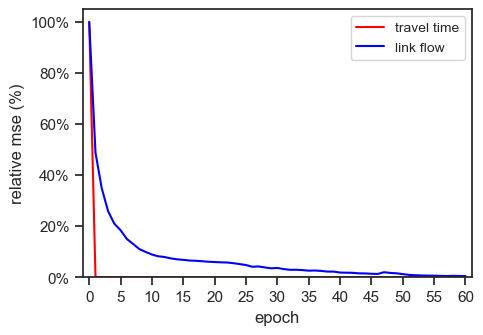

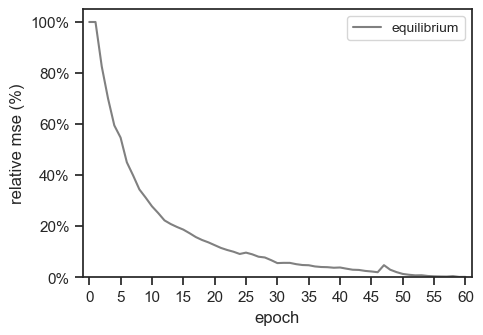

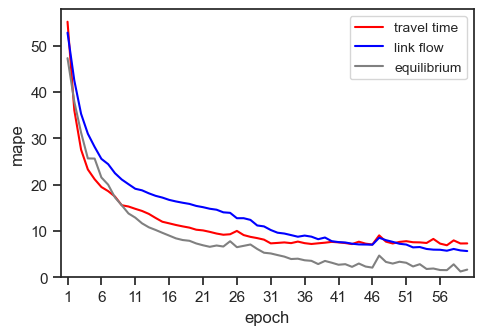

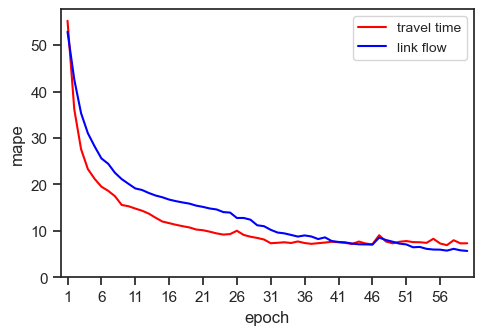

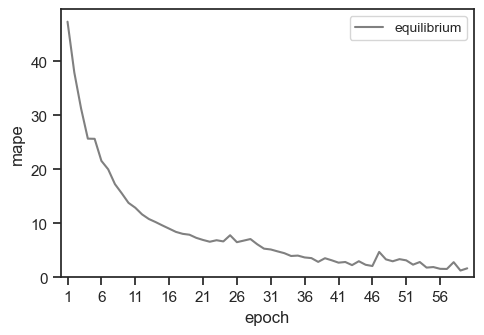

In [39]:
plot_predictive_performance(train_losses=train_results_dfs['tvgodlulpe'],
                            val_losses=val_results_dfs['tvgodlulpe'], show_validation=False,
                            xticks_spacing=5,
                            epochs_end_learning_stage=_EPOCHS['learning'])

plot_predictive_performance(train_losses=train_results_dfs['tvgodlulpe'],
                            # val_losses=val_results_dfs['tvgodlulpe'],
                            curves = ['link flow', 'travel time'],
                            xticks_spacing=5, show_validation=False,
                            epochs_end_learning_stage=_EPOCHS['learning'])

plt.savefig('output/figures/experiments/siouxfalls-relative-mse-tvgodlulpe.png')

plot_predictive_performance(train_losses=train_results_dfs['tvgodlulpe'],
                            val_losses=val_results_dfs['tvgodlulpe'], show_validation=False,
                            xticks_spacing=5,
                            curves=['equilibrium'],
                            epochs_end_learning_stage=_EPOCHS['learning'])


plot_predictive_performance(train_losses=train_results_dfs['tvgodlulpe'][train_results_dfs['tvgodlulpe'].epoch>0],
                                      val_losses=val_results_dfs['tvgodlulpe'], show_validation=False,
                                      xticks_spacing=5,
                                      # curves = ['link flow', 'travel time'],
                                      epochs_end_learning_stage=_EPOCHS['learning'], prefix_metric='mape',
                                      yaxis_label='mape')

plot_predictive_performance(train_losses=train_results_dfs['tvgodlulpe'][train_results_dfs['tvgodlulpe'].epoch>0],
                                      val_losses=val_results_dfs['tvgodlulpe'], show_validation=False,
                                      xticks_spacing=5,
                                      curves = ['link flow', 'travel time'],
                                      epochs_end_learning_stage=_EPOCHS['learning'], prefix_metric='mape',
                                      yaxis_label='mape')

plt.savefig('output/figures/experiments/siouxfalls-mape-tvgodlulpe.png')

plot_predictive_performance(train_losses=train_results_dfs['tvgodlulpe'][train_results_dfs['tvgodlulpe'].epoch>0],
                                      val_losses=val_results_dfs['tvgodlulpe'], show_validation=False,
                                      xticks_spacing=5,
                                      curves=['equilibrium'],
                                      epochs_end_learning_stage=_EPOCHS['learning'], prefix_metric='mape',
                                      yaxis_label='mape')

plt.show()

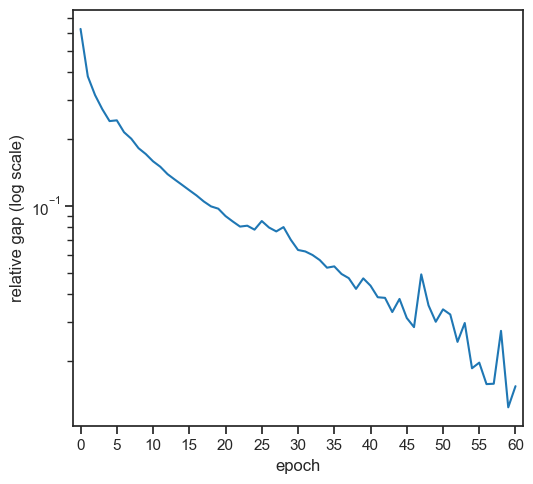

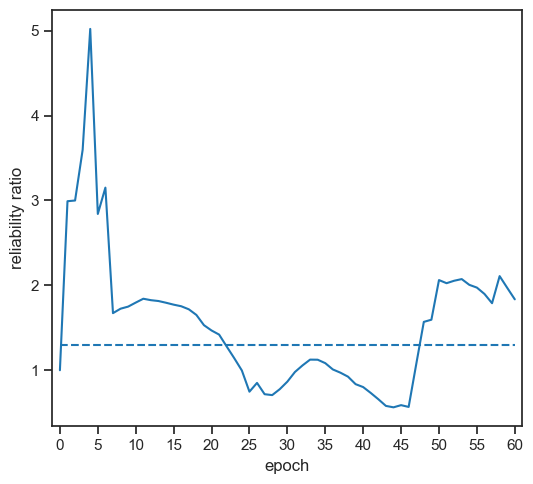

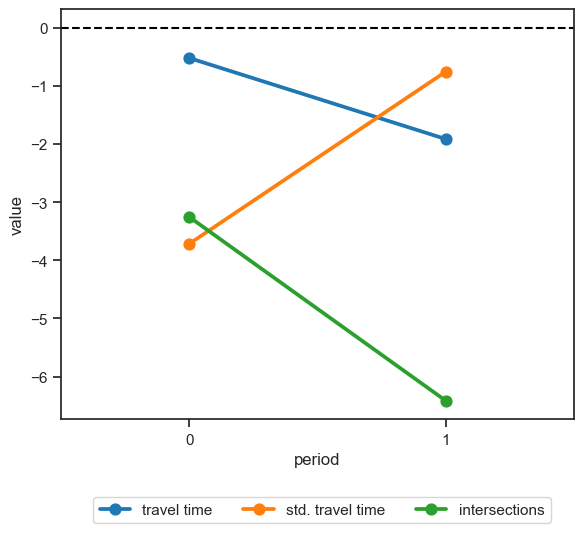

   period         parameter     value    group
0       0       travel time -0.521323  utility
1       1       travel time -1.914299  utility
2       0  std. travel time -3.714423  utility
3       1  std. travel time -0.755129  utility
4       0     intersections -3.255653  utility
5       1     intersections -6.414458  utility


In [40]:
fig, ax = plot_convergence_estimates(
    estimates=train_results_dfs['tvgodlulpe'].assign(
        relative_gap=np.abs(train_results_dfs['tvgodlulpe']['relative_gap']))[['epoch', 'relative_gap']],
    xticks_spacing=5)

ax.set_yscale('log')
ax.set_ylabel('relative gap (log scale)')
ax.get_legend().remove()

plt.savefig('output/figures/experiments/siouxfalls-relative-gap-tvgodlulpe.png')

plt.show()

fig, ax = plot_convergence_estimates(estimates=train_results_dfs['tvgodlulpe']. \
                                     assign(rr=train_results_dfs['tvgodlulpe']['tt_sd'] / train_results_dfs['tvgodlulpe']['tt'])[['epoch', 'rr']],
                                     true_values={'rr': models['tvgodlulpe'].utility.true_values['tt_sd']/models['tvgodlulpe'].utility.true_values['tt']},
                                     xticks_spacing=5)
# ax.legend(loc = 'lower right')
ax.get_legend().remove()
ax.set_ylabel("reliability ratio")
plt.show()

# Utility by period
theta_df = plot_utility_parameters_periods(models['tvgodlulpe'], period_keys=period_keys, period_feature='hour', plot = False).reset_index().drop(['hour','index'], axis = 1).reset_index().rename(columns = {'index':'period'})

# theta_df = pd.melt(theta_df.assign(rr = theta_df.apply(compute_rr, axis=1)), id_vars = 'period', var_name = 'parameter').assign(group = 'utility').\
#     replace({'tt': 'travel time', 'tt_sd': 'std. travel time', 's': 'intersections', 'rr': 'reliability ratio'})

theta_df = pd.melt(theta_df, id_vars = 'period', var_name = 'parameter').assign(group = 'utility').replace({'tt': 'travel time', 'tt_sd': 'std. travel time', 's': 'intersections'})

fig, axs = plot_parameters(df = theta_df, n_cols_legend = 3, figsize = (6,5.5))

plt.axhline(0, linestyle ='dashed', color = 'black')

plt.savefig(f'output/figures/experiments/siouxfalls-utility-periods-tvgodlulpe.png')

plt.show()

print(theta_df)

/Users/pablo/github/nesuelogit/src/nesuelogit/visualizations.py:879: UserWarning: 

The `join` parameter is deprecated and will be removed in v0.15.0. You can remove the line between points with `linestyle='none'`.

  g = sns.pointplot(data=total_trips_by_hour, x=period_feature, y='total_trips', ax=ax,


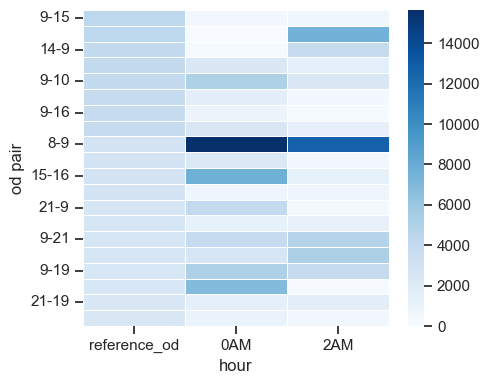

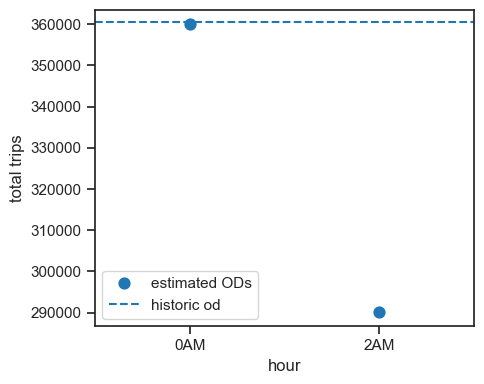

In [41]:
# Plot heatmap with flows of top od pairs
plot_top_od_flows_periods(models['tvgodlulpe'], period_keys=period_keys, period_feature=period_feature, top_k=20,
                          reference_od=network.q.flatten())
plt.show()

period 0

correlation: 0.45015674232496183


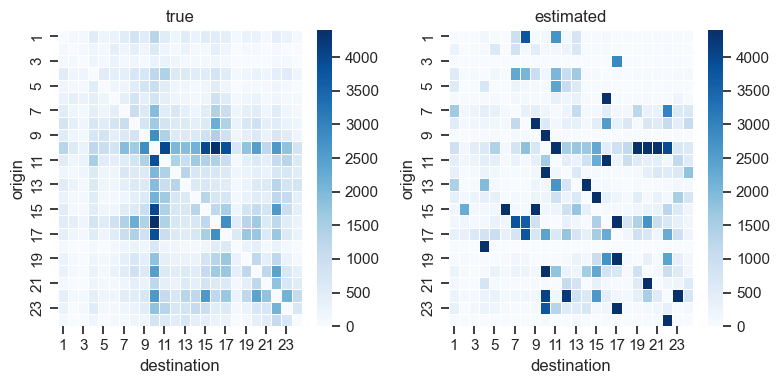

period 1

correlation: 0.45589941205372375


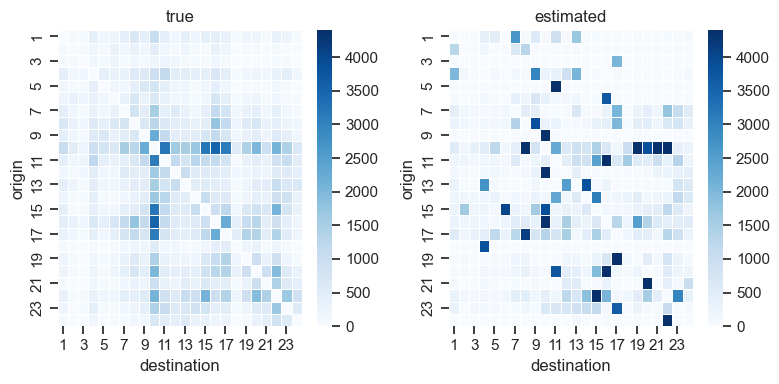

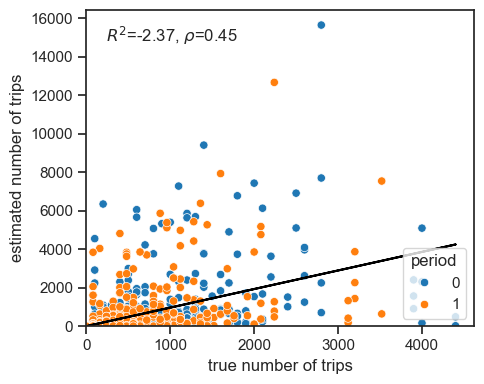

In [42]:
estimated_Q = models['tvgodlulpe'].Q.numpy()
plot_data = pd.DataFrame()

for period in range(estimated_Q.shape[0]):
    print(f'period {period}\n')
    Qs = {'true': Q_true[period], 'estimated': estimated_Q[period]}  # 'historic': Q_historic,

    rho_val, p = sp.stats.pearsonr(Qs["true"].flatten(), Qs["estimated"].flatten())
    print(f'correlation: {rho_val}')

    plot_heatmap_demands(Qs=Qs, vmin=np.min(Q_true[0]), vmax=np.max(Q_true[0]), subplots_dims=(1, len(Qs.keys())),
                         figsize=(4*len(Qs.keys()), 4))
    plt.show()

    plot_data = pd.concat([plot_data, pd.DataFrame({'true': Qs['true'].flatten(), 'estimated':Qs['estimated'].flatten(),
                                                    'period': period})])

fig, ax = plt.subplots(1, 1, figsize=(5, 4), tight_layout=True)
sns.scatterplot(data=plot_data, x='true', y='estimated', hue = 'period', ax = ax)
plot_annotate_r2(ax=ax, x=plot_data['true'], y=plot_data['estimated'], intercept = False, r2 = True, rho = True)
ax.set_xlabel('true number of trips')
ax.set_ylabel('estimated number of trips')
ax.legend(loc='lower right', title = 'period')
ax.set_xlim(xmin=-1e-2)
ax.set_ylim(ymin=-1e-2)

plt.savefig(f'output/figures/experiments/siouxfalls-scatter-ode-tvgodlulpe.png')

plt.show()

In [43]:
print(f"theta = "
      f"{dict(zip(models['tvgodlulpe'].utility.true_values.keys(), list(np.mean(models['tvgodlulpe'].theta.numpy(), axis=0))))}")
if models['tvgodlulpe']._kappa is not None:
    print(f"kappa= "
          f"{dict(zip(models['tvgodlulpe'].generation.features, list(np.mean(models['tvgodlulpe'].kappa.numpy(), axis=0))))}")

print(f"Avg abs diff of observed and estimated OD: "
      f"{np.mean(np.abs(models['tvgodlulpe'].q - network.q.flatten())): 0.2f}")

print(f"Avg observed OD: {np.mean(np.abs(network.q.flatten())): 0.2f}")

theta = {'tt': -1.2178112, 'tt_sd': -2.234776, 's': -4.8350554}
Avg abs diff of observed and estimated OD:  649.39
Avg observed OD:  682.95


In [44]:
metrics_df = models['tvgodlulpe'].compute_loss_metrics(metrics={'mape': mape, 'mse': mse, 'r2': r2_score},
                                                      X=XT_train, Y=YT_train).assign(dataset='training')

if YT_val is not None:
    metrics_df = pd.concat([metrics_df,
                            models['tvgodlulpe'].compute_loss_metrics(metrics={'mape': mape, 'mse': mse, 'r2': r2_score},
                                                                     X=XT_val, Y=YT_val).assign(dataset='validation'),
                            compute_benchmark_metrics(metrics={'mape': mape, 'mse': mse, 'r2': r2_score}, Y_ref=YT_train,
                                                      Y=YT_val).assign(dataset='benchmark')
                            ])

with pd.option_context('display.float_format', '{:0.2g}'.format):
    print(pd.pivot(metrics_df, index=['component', 'dataset'], columns=['metric'])['value'])

metric                mape     mse   r2
component   dataset                    
equilibrium training   1.7   8e+04    1
flow        training   5.7 4.4e+05 0.98
traveltime  training   7.3    0.31 0.99


### Predictive performance

In [45]:
inference_model = create_tvgodlulpe_model_tntp(network=network, n_periods=n_periods, features_Z=_FEATURES_Z,
                                               reference_g = generated_trips, reference_q = q_historic)

inference_model.build()

inference_model.load_weights(models['tvgodlulpe']._filepath_weights)

In [46]:
_ = inference_model.predict(XT_train,
                        node_data=node_data,
                        loss_metric=_LOSS_METRIC,
                        batch_size= None,
                        optimizer= tf.keras.optimizers.legacy.Adam(learning_rate=1e-1),
                        loss_weights={'equilibrium': 1},
                        pretrain_link_flows = False,
                        threshold_relative_gap=_RELATIVE_GAP,
                        epochs=200)

with pd.option_context('display.float_format', '{:0.3g}'.format):
    print('\n')
    print(inference_model.compute_loss_metrics(metrics={'mape': mape, 'mse': mse, 'r2': r2_score}, X=XT_train, Y=YT_train))


Computing gradient based equilibrium

Model training

hyperparameters loss function: {'equilibrium': 1}

number of periods: 2, batch size: 300, threshold relative gap: inf
training set -> timepoints: 300, obs [t x]: nan, coverage [t x]: nan

0/200: train mse=8e+04, avg theta = [-1.218 -2.235 -4.835], avg rr = 1.84, avg theta fixed effect = -0.1, loss prop od=0, total trips=[3.60e+05 2.90e+05], polynomial weights: [5.9e-04 4.4e-03 4.3e-02], lambda eq=1, relative gap=0.015, train equilibrium loss=8e+04, time: 0.1

Relative gap threshold of inf was achieved in equilibrium stage


     component    value metric
0         flow     5.66   mape
1   traveltime     7.32   mape
2  equilibrium     1.65   mape
0         flow 4.39e+05    mse
1   traveltime    0.306    mse
2  equilibrium 7.95e+04    mse
0         flow    0.977     r2
1   traveltime     0.99     r2
2  equilibrium    0.996     r2


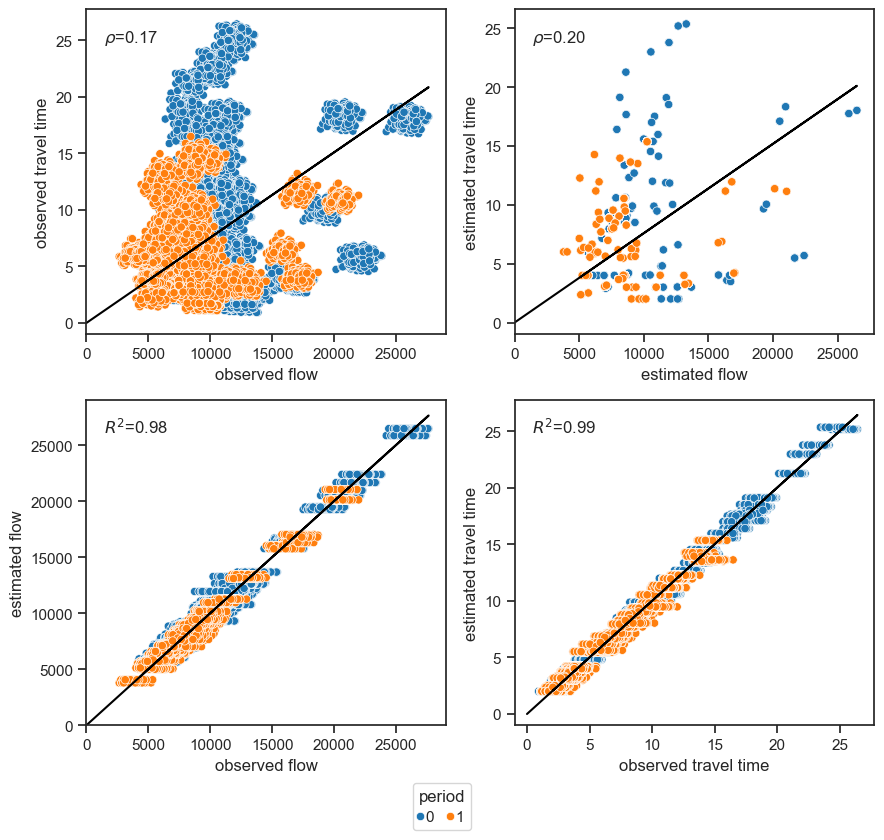

In [47]:
fig, axs = plot_flow_vs_traveltime(model = inference_model,
                        observed_traveltime=inference_model.mask_observed_traveltime(YT_train[:, :, 0]),
                        observed_flow= inference_model.mask_observed_flow(YT_train[:,:,1]),
                        period_col = X[:,:,-1].numpy().astype(int).flatten(),
                        ampm_format = False,
                        all_metrics = False)

for ax in axs.reshape(-1):
    ax.set_xlim(xmin=-10)
    ax.set_ylim(ymin=-1)

axs[1,1].set_xlim(xmin=-1)

plt.show()

## c) Comparisons

### i) ODE

period 0



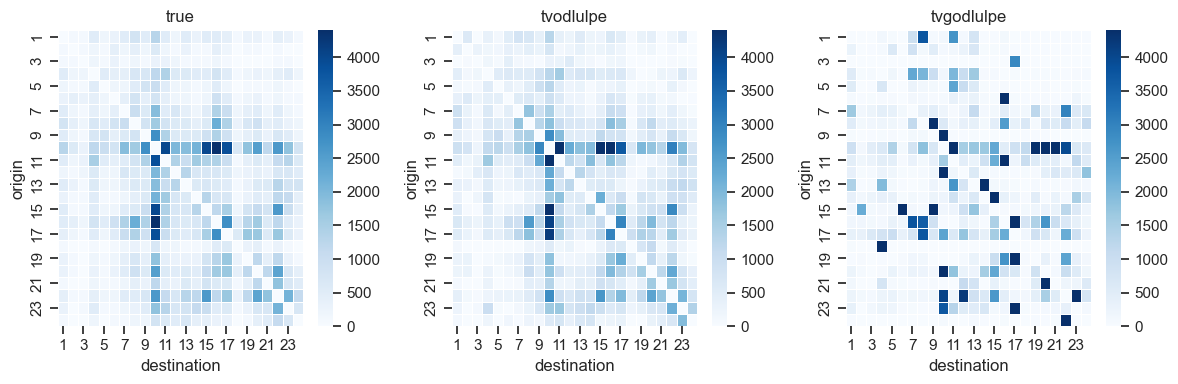

period 1



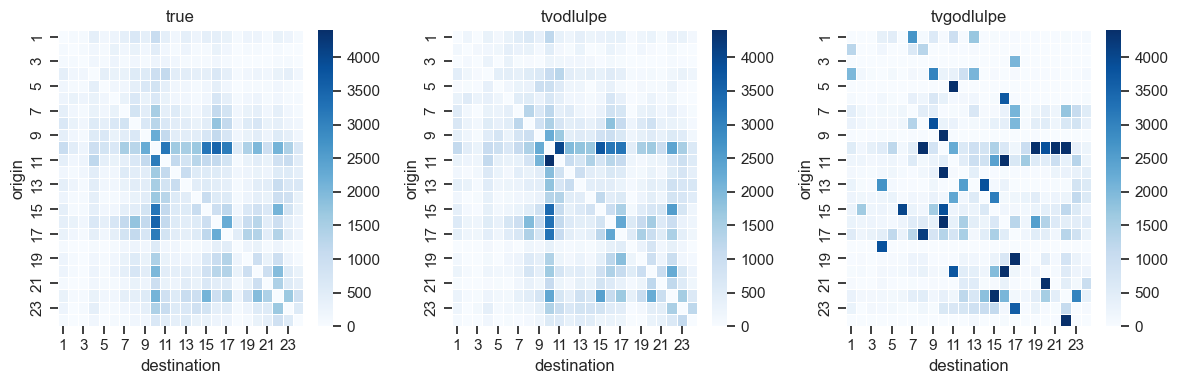

In [48]:
for period in range(n_periods):
    print(f'period {period}\n')
    Qs = {'true': Q_true[period], 'tvodlulpe': models['tvodlulpe'].Q.numpy()[period], 'tvgodlulpe': models['tvgodlulpe'].Q.numpy()[period]}  # 'historic': Q_historic,

    plot_heatmap_demands(Qs=Qs, vmin=np.min(Q_true[0]), vmax=np.max(Q_true[0]), subplots_dims=(1, len(Qs.keys())),
                         figsize=(4*len(Qs.keys()), 4))

    plt.savefig(f'output/figures/experiments/siouxfalls-comparison-heatmaps-ode-period-{period}.png')

    plt.show()

## K-Fold Cross Validation

In [49]:
_MLP_KFOLD = create_mlp_tntp(network=network, diagonal=True, homogenous=True, poly_order = _POLY_ORDER, dtype=_DTYPE, pretrain = False, link_specific = False)

# It is important to initialize utility around true values, in this case we choose to initialize with the prior signs.
_UTILITY_KFOLD = UtilityParameters(features_Y=['tt'],
                                   features_Z=_FEATURES_Z,
                                   initial_values={
                                       'tt': -1, 'tt_sd': -1, 's': -1, 'psc_factor': 0,
                                                   'fixed_effect': np.zeros_like(network.links)},
                                   trainables={'tt': True, 'tt_sd': True, 's': True,
                                               'psc_factor': False, 'fixed_effect': False},
                                   time_varying=True,
                                   dtype=_DTYPE
                                   )

In [50]:
models_kfold = {}
metrics_kfold = {}
parameters_kfold = {}

### a) Comparison between MLP and BPR assuming known utility and OD

#### i) MLP

In [51]:
models_kfold['tvlpe-mlp'] = create_model_tntp(
    n_periods=n_periods, network=network,
    reference_g= generated_trips,
    performance_function = _MLP_KFOLD,
    utility = False,
    features_Z= _FEATURES_Z,
    od_parameters = ODParameters(key='od',
                             initial_values= q_true,
                             ods=network.ods,
                             n_nodes = len(network.nodes),
                             n_periods=n_periods,
                             time_varying=True,
                             trainable=False),
    generation = False,
)[0]

metrics_kfold['tvlpe-mlp'], parameters_kfold['tvlpe-mlp'] = train_kfold(
    n_splits=_N_SPLITS,
    random_state=_SEED,
    model= models_kfold['tvlpe-mlp'],
    X=X, Y=Y,
    optimizers= _OPTIMIZERS,
    node_data=node_data,
    loss_weights= _LOSS_WEIGHTS_KFOLD,
    loss_metric = _LOSS_METRIC,
    threshold_relative_gap=_RELATIVE_GAP,
    batch_size=_BATCH_SIZE,
    epochs_print_interval=_EPOCHS_KFOLD.copy(),
    epochs= _EPOCHS_KFOLD
)

metrics_kfold['tvlpe-mlp'].to_csv(f"./output/experiments/{datetime.now().strftime('%y%m%d%H%M%S')}_kfold_tvlpe-mlp_{network_name}.csv")

2023-12-20 11:40:02.652867: W tensorflow/core/platform/profile_utils/cpu_utils.cc:128] Failed to get CPU frequency: 0 Hz



Fold 1/5

Model training

Link flows and travel times were pretrained with single pass of traffic assignment
Benchmark metrics using historical mean in training data to make predictions in the validation set: 


    component   value metric
0        flow      37   mape
1  traveltime 1.1e+02   mape
0        flow 1.6e+07    mse
1  traveltime      23    mse
0        flow  -0.029     r2
1  traveltime   -0.64     r2

hyperparameters loss function: {'od': 0, 'traveltime': 1, 'flow': 1, 'equilibrium': 1}

number of periods: 2, batch size: 1, threshold relative gap: inf
training set -> timepoints: 300, obs [t x]: [60. 60.], coverage [t x]: [0.79 0.79]
validation set -> timepoints: 300, obs [t x]: [16. 16.], coverage [t x]: [0.21 0.21]

Learning stage: 60 epochs

0/60: train mse=4.5e+07, train mse traveltime=3.8e+04, train mape traveltime=808.0 train mse flow=4.1e+07, train mape flow=52.4, val mse=3.7e+07, val mse traveltime=9.4e+02, val mape traveltime=320.2 val mse flow=1.7e+07, val mape flo

In [52]:
with pd.option_context('display.float_format', '{:0.2g}'.format):
    # print(metrics_kfold_df[metrics_kfold_df.component.isin(['flow','tt'])].\
    #       groupby(['dataset', 'component', 'metric', 'stage'])['value'].\
    #       aggregate(['mean', 'std']))
    print(metrics_kfold['tvlpe-mlp']. \
          groupby(['dataset', 'component', 'metric', 'stage'])['value']. \
          aggregate(['median', 'mean', 'std']))

                                                median     mean     std
dataset    component   metric stage                                    
training   equilibrium mape   final                1.5      1.6    0.33
                              initial            1e+02    1e+02       0
                       mse    final            4.3e+04    5e+04 2.2e+04
                              initial          9.3e+07  9.3e+07       0
                       r2     final                  1        1  0.0012
                              initial             -1.3     -1.3       0
           flow        mape   final                5.5      5.5    0.24
                              historical mean       32       32       1
                              initial               47       48     2.6
                       mse    final              4e+05  4.2e+05 6.2e+04
                              historical mean    2e+07  1.9e+07 1.9e+06
                              initial          3.6e+07  3.6e+07 

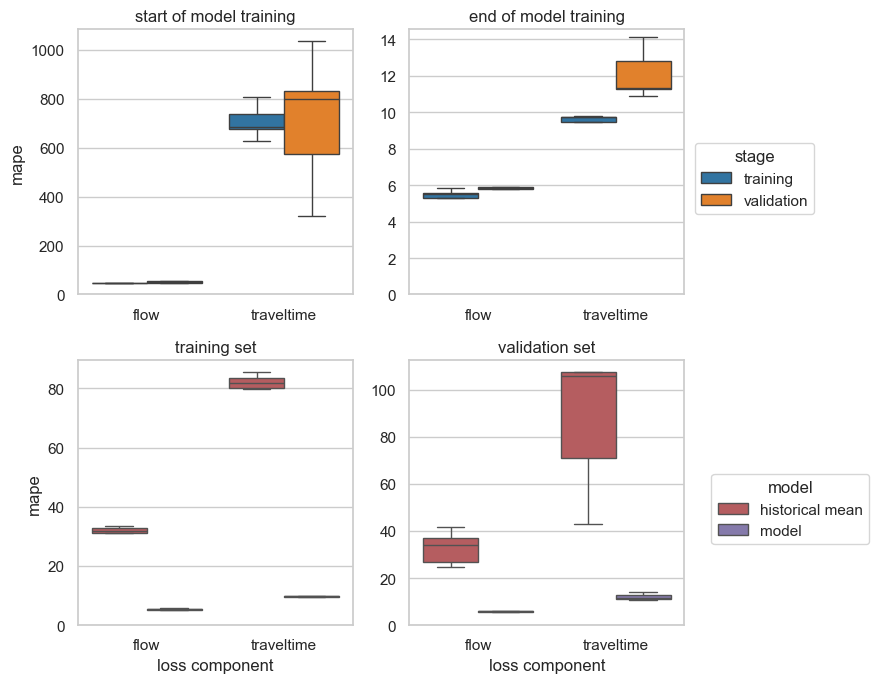

In [53]:
fig, axs = plot_metrics_kfold(df=metrics_kfold['tvlpe-mlp'][metrics_kfold['tvlpe-mlp'].component.isin(['flow', 'traveltime'])], metric_name = 'mape', showfliers = False, sharey=False)
for ax in axs.reshape(-1):
    ax.set_ylim(bottom = 0)
plt.savefig('output/figures/experiments/siouxfalls-kfold-mape-tvlpe-mlp.png')

(<Figure size 900x700 with 4 Axes>,
 array([[<Axes: title={'center': 'start of model training'}, xlabel='loss component', ylabel='r2'>,
         <Axes: title={'center': 'end of model training'}, xlabel='loss component', ylabel='r2'>],
        [<Axes: title={'center': 'training set'}, xlabel='loss component', ylabel='r2'>,
         <Axes: title={'center': 'validation set'}, xlabel='loss component', ylabel='r2'>]],
       dtype=object))

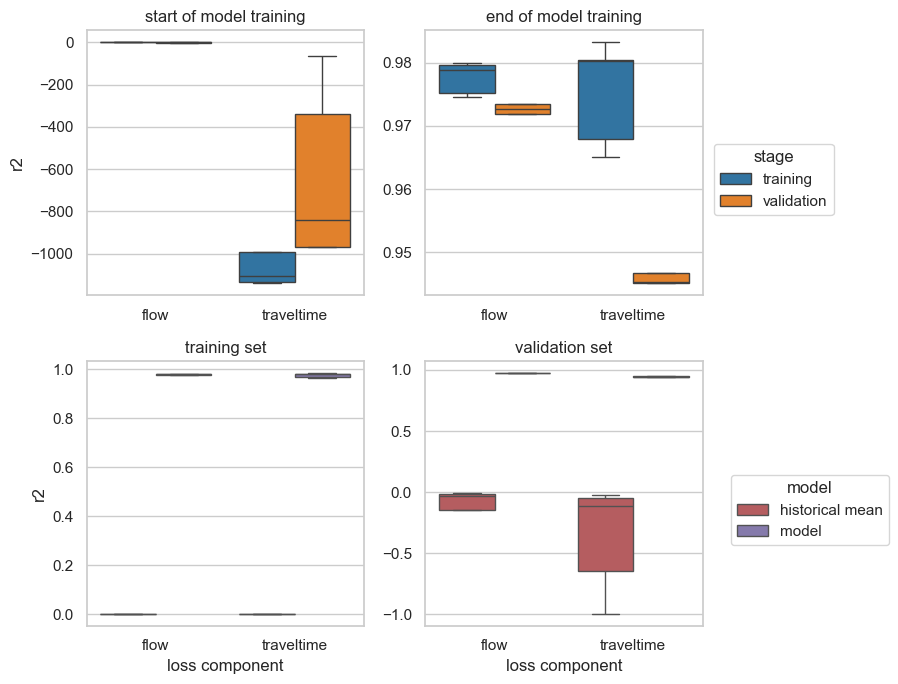

In [54]:
plot_metrics_kfold(df=metrics_kfold['tvlpe-mlp'][metrics_kfold['tvlpe-mlp'].component.isin(['flow', 'traveltime'])], metric_name = 'r2', showfliers = False, sharey=False)

#### ii) BPR

In [ ]:
models_kfold['tvlpe-bpr'] = create_model_tntp(
    n_periods=n_periods, network=network,
    reference_g=generated_trips,
    performance_function = create_bpr(network = network, dtype = _DTYPE),
    utility = False,
    features_Z=_FEATURES_Z,
    od_parameters = ODParameters(key='od',
                             initial_values= q_true,
                             ods=network.ods,
                             n_nodes = len(network.nodes),
                             n_periods=n_periods,
                             time_varying=True,
                             trainable=False),
    generation = False,

)[0]


metrics_kfold['tvlpe-bpr'], parameters_kfold['tvlpe-bpr'] = train_kfold(
    n_splits=_N_SPLITS,
    random_state=_SEED,
    model= models_kfold['tvlpe-bpr'],
    X=X, Y=Y,
    optimizers= _OPTIMIZERS,
    node_data=node_data,
    loss_weights= _LOSS_WEIGHTS_KFOLD,
    loss_metric = _LOSS_METRIC,
    threshold_relative_gap=_RELATIVE_GAP,
    batch_size=_BATCH_SIZE,
    epochs_print_interval= _EPOCHS_KFOLD.copy(),
    epochs= _EPOCHS_KFOLD
)

metrics_kfold['tvlpe-bpr'].to_csv(f"./output/experiments/{datetime.now().strftime('%y%m%d%H%M%S')}_kfold_tvlpe-bpr_{network_name}.csv")


Fold 1/5

Model training

Link flows and travel times were pretrained with single pass of traffic assignment
Benchmark metrics using historical mean in training data to make predictions in the validation set: 


    component   value metric
0        flow      37   mape
1  traveltime 1.1e+02   mape
0        flow 1.6e+07    mse
1  traveltime      23    mse
0        flow  -0.029     r2
1  traveltime   -0.64     r2

hyperparameters loss function: {'od': 0, 'traveltime': 1, 'flow': 1, 'equilibrium': 1.0}

number of periods: 2, batch size: 1, threshold relative gap: inf
training set -> timepoints: 300, obs [t x]: [60. 60.], coverage [t x]: [0.79 0.79]
validation set -> timepoints: 300, obs [t x]: [16. 16.], coverage [t x]: [0.21 0.21]

Learning stage: 60 epochs

0/60: train mse=1.5e+07, train mse traveltime=26, train mape traveltime=42.3 train mse flow=7.1e+06, train mape flow=16.9, val mse=1.4e+07, val mse traveltime=6.6, val mape traveltime=42.7 val mse flow=3e+06, val mape flow=13.0, avg

In [ ]:
with pd.option_context('display.float_format', '{:0.2g}'.format):
    # print(metrics_kfold_df[metrics_kfold_df.component.isin(['flow','tt'])].\
    #       groupby(['dataset', 'component', 'metric', 'stage'])['value'].\
    #       aggregate(['mean', 'std']))
    print(metrics_kfold['tvlpe-bpr']. \
          groupby(['dataset', 'component', 'metric', 'stage'])['value']. \
          aggregate(['median', 'mean', 'std']))

In [ ]:
fig, axs = plot_metrics_kfold(df=metrics_kfold['tvlpe-bpr'][metrics_kfold['tvlpe-bpr'].component.isin(['flow', 'traveltime'])], metric_name = 'mape', showfliers = False, sharey=False)
for ax in axs.reshape(-1):
    ax.set_ylim(bottom = 0)
plt.savefig('output/figures/experiments/siouxfalls-kfold-mape-tvlpe-bpr.png')

In [ ]:
plot_metrics_kfold(df=metrics_kfold['tvlpe-bpr'][metrics_kfold['tvlpe-bpr'].component.isin(['flow', 'traveltime'])], metric_name = 'r2', showfliers = False, sharey=False)

### b) Impact of estimating utility function

In [ ]:
models_kfold['tvlulpe-mlp'] = create_model_tntp(
    n_periods=n_periods, network=network,
    performance_function = _MLP_KFOLD,
    utility = True,
    utility_parameters=_UTILITY_KFOLD,
    od_parameters = ODParameters(key='od',
                             #initial_values= generation_factors.values[:,np.newaxis]*network.q.flatten(),
                             initial_values= q_true,
                             ods=network.ods,
                             n_nodes = len(network.nodes),
                             n_periods=n_periods,
                             time_varying=True,
                             trainable=False),
    generation = False,
      # reference_g= generated_trips,
)[0]

metrics_kfold['tvlulpe-mlp'], parameters_kfold['tvlulpe-mlp'] = train_kfold(
    n_splits=_N_SPLITS,
    random_state=_SEED,
    model= models_kfold['tvlulpe-mlp'],
    X=X, Y=Y,
    optimizers= _OPTIMIZERS,
    node_data=node_data,
    loss_weights= _LOSS_WEIGHTS_KFOLD,
    loss_metric = _LOSS_METRIC,
    threshold_relative_gap=_RELATIVE_GAP,
    batch_size=_BATCH_SIZE,
    epochs_print_interval=_EPOCHS_KFOLD.copy(),
    epochs= _EPOCHS_KFOLD
)

metrics_kfold['tvlulpe-mlp'].to_csv(f"./output/experiments/{datetime.now().strftime('%y%m%d%H%M%S')}_kfold_tvlulpe-mlp_{network_name}.csv")

In [ ]:
with pd.option_context('display.float_format', '{:0.2g}'.format):
    # print(metrics_kfold_df[metrics_kfold_df.component.isin(['flow','tt'])].\
    #       groupby(['dataset', 'component', 'metric', 'stage'])['value'].\
    #       aggregate(['mean', 'std']))
    print(metrics_kfold['tvlulpe-mlp']. \
          groupby(['dataset', 'component', 'metric', 'stage'])['value']. \
          aggregate(['median', 'mean', 'std']))

In [ ]:
fig, axs = plot_metrics_kfold(df=metrics_kfold['tvlulpe-mlp'][metrics_kfold['tvlulpe-mlp'].component.isin(['flow', 'traveltime'])], metric_name = 'mape', showfliers = False, sharey=False)
for ax in axs.reshape(-1):
    ax.set_ylim(bottom = 0)

In [ ]:
plot_metrics_kfold(df=metrics_kfold['tvlulpe-mlp'][metrics_kfold['tvlulpe-mlp'].component.isin(['flow', 'traveltime'])], metric_name = 'r2', showfliers = False, sharey = False)

In [ ]:
parameters_kfold['tvlulpe-mlp']['hour'] = parameters_kfold['tvlulpe-mlp'].period.replace({v: k for k, v in models_kfold['tvlulpe-mlp'].period_dict.items()}). \
    replace(dict(zip(period_keys.period_id, period_keys.hour)))

parameters_kfold['tvlulpe-mlp']['parameter'] = parameters_kfold['tvlulpe-mlp']['parameter'].replace({'tt': 'travel time', 'tt_sd': 'std. travel time', 'vot': 'reliability ratio', 's': 'intersections'})

parameters_kfold['tvlulpe-mlp'] = parameters_kfold['tvlulpe-mlp'][parameters_kfold['tvlulpe-mlp'].parameter != 'reliability ratio']

fig, axs = plot_parameters_kfold(df = parameters_kfold['tvlulpe-mlp'], join=True, n_cols_legend = 3, figsize = (6,5.5))

plt.axhline(0, linestyle ='dashed', color = 'black')

plt.savefig('output/figures/experiments/siouxfalls-kfold-utility-periods-tvgodlulpe.png')

# TODO: Add horizontal lines with the same colors for true values

#parameters_kfold['tvlulpe-mlp']

### c) Effect of OD estimation

#### i) Traditional ODE without generation stage and historic O-D matrix

In [ ]:
models_kfold['tvodlulpe-mlp'] = create_model_tntp(
    n_periods=n_periods, network=network,
    model_key = 'tvgodlulpe',
    performance_function= _MLP_KFOLD,
    utility=True,
    utility_parameters=_UTILITY_KFOLD,
    generation=False,
    # reference_g=generated_trips,
    od_parameters=ODParameters(key='od',
                               #initial_values= generation_factors.values[:,np.newaxis]*network.q.flatten(),
                               initial_values=q_true,
                               reference_values={0: q_historic[0], 1:q_historic[1]},
                               ods=network.ods,
                               n_nodes = len(network.nodes),
                               n_periods=n_periods,
                               time_varying=True,
                               trainable=True),

)[0]

metrics_kfold['tvodlulpe-mlp'], parameters_kfold['tvodlulpe-mlp'] = train_kfold(
    n_splits=_N_SPLITS,
    random_state=_SEED,
    model=models_kfold['tvodlulpe-mlp'],
    X=X, Y=Y,
    optimizers=_OPTIMIZERS,
    node_data=node_data,
    loss_weights= _LOSS_WEIGHTS_KFOLD,
    loss_metric=_LOSS_METRIC,
    threshold_relative_gap=_RELATIVE_GAP,
    batch_size=_BATCH_SIZE,
    epochs_print_interval=_EPOCHS_KFOLD.copy(),
    epochs=_EPOCHS_KFOLD
)
metrics_kfold['tvodlulpe-mlp'].to_csv(f"./output/experiments/{datetime.now().strftime('%y%m%d%H%M%S')}_kfold_tvodlulpe-mlp_{network_name}.csv")

In [ ]:

with pd.option_context('display.float_format', '{:0.2g}'.format):
    # print(metrics_kfold_df[metrics_kfold_df.component.isin(['flow','tt'])].\
    #       groupby(['dataset', 'component', 'metric', 'stage'])['value'].\
    #       aggregate(['mean', 'std']))
    print(metrics_kfold['tvodlulpe-mlp']. \
          groupby(['dataset', 'component', 'metric', 'stage'])['value']. \
          aggregate(['median', 'mean', 'std']))

In [ ]:
fig, axs = plot_metrics_kfold(df=metrics_kfold['tvodlulpe-mlp'][metrics_kfold['tvodlulpe-mlp'].component.isin(['flow', 'traveltime'])],
                   metric_name='mape', showfliers=False, sharey=False)
for ax in axs.reshape(-1):
    ax.set_ylim(bottom = 0)

plt.savefig('output/figures/experiments/siouxfalls-kfold-mape-tvodlulpe-mlp.png')

In [ ]:
plot_metrics_kfold(df=metrics_kfold['tvodlulpe-mlp'][metrics_kfold['tvodlulpe-mlp'].component.isin(['flow', 'traveltime'])],
                   metric_name='r2', showfliers=False, sharey=False)

In [ ]:
# parameters_kfold['tvodlulpe-mlp']['hour'] = parameters_kfold['tvodlulpe-mlp'].period.replace({v: k for k, v in models_kfold['tvodlulpe-mlp'].period_dict.items()}). \
#     replace(dict(zip(period_keys.period_id, period_keys.hour)))

# parameters_kfold['tvodlulpe-mlp']['hour'] = parameters_kfold['tvodlulpe-mlp'].period.replace({v: k for k, v in models_kfold['tvodlulpe-mlp'].period_dict.items()}). \
#     replace(dict(zip(period_keys.period_id, period_keys.hour)))

parameters_kfold['tvodlulpe-mlp']['parameter'] = parameters_kfold['tvodlulpe-mlp']['parameter'].\
    replace({'tt': 'travel time', 'tt_sd': 'std. travel time', 's': 'intersections', 'vot': 'reliability ratio'})

parameters_kfold['tvodlulpe-mlp'] = parameters_kfold['tvodlulpe-mlp'][parameters_kfold['tvodlulpe-mlp'].parameter != 'reliability ratio']

plot_parameters_kfold(df=parameters_kfold['tvodlulpe-mlp'], join=True, n_cols_legend = 3, figsize = (6,5.5))

plt.axhline(0, linestyle ='dashed', color = 'black')

plt.savefig('output/figures/experiments/siouxfalls-kfold-utility-periods-tvodlulpe-mlp')

plt.show()

#### ii) ODE with generation and with historic trip generation matrix

In [ ]:
models_kfold['tvgodlulpe'] = create_model_tntp(
    n_periods=n_periods, network=network,
    performance_function= _MLP_KFOLD,
    utility=True,
    utility_parameters=_UTILITY_KFOLD,
    generation=True,
    reference_g=generated_trips
)[0]

metrics_kfold['tvgodlulpe'], parameters_kfold['tvgodlulpe'] = train_kfold(
    n_splits=_N_SPLITS,
    random_state=_SEED,
    model=models_kfold['tvgodlulpe'],
    X=X, Y=Y,
    optimizers=_OPTIMIZERS,
    node_data=node_data,
    loss_weights= _LOSS_WEIGHTS_KFOLD,
    loss_metric=_LOSS_METRIC,
    threshold_relative_gap=_RELATIVE_GAP,
    batch_size=_BATCH_SIZE,
    epochs_print_interval=_EPOCHS_KFOLD.copy(),
    epochs=_EPOCHS_KFOLD
)

metrics_kfold['tvgodlulpe'].to_csv(f"./output/experiments/{datetime.now().strftime('%y%m%d%H%M%S')}_kfold_tvgodlulpe-mlp_{network_name}.csv")

In [ ]:
with pd.option_context('display.float_format', '{:0.2g}'.format):
    # print(metrics_kfold_df[metrics_kfold_df.component.isin(['flow','tt'])].\
    #       groupby(['dataset', 'component', 'metric', 'stage'])['value'].\
    #       aggregate(['mean', 'std']))
    print(metrics_kfold['tvgodlulpe']. \
          groupby(['dataset', 'component', 'metric', 'stage'])['value']. \
          aggregate(['median', 'mean', 'std']))

In [ ]:
fig, axs = plot_metrics_kfold(df=metrics_kfold['tvgodlulpe'][metrics_kfold['tvgodlulpe'].component.isin(['flow', 'traveltime'])],
                   metric_name='mape', showfliers=False, sharey=False)
for ax in axs.reshape(-1):
    ax.set_ylim(bottom = 0)

plt.savefig('output/figures/experiments/siouxfalls-kfold-mape-tvgodlulpe')

In [ ]:
plot_metrics_kfold(df=metrics_kfold['tvgodlulpe'][metrics_kfold['tvgodlulpe'].component.isin(['flow', 'traveltime'])],
                   metric_name='r2', showfliers=False, sharey=False)

In [ ]:
parameters_kfold['tvgodlulpe']['hour'] = parameters_kfold['tvgodlulpe'].period.replace({v: k for k, v in models_kfold['tvgodlulpe'].period_dict.items()}). \
    replace(dict(zip(period_keys.period_id, period_keys.hour)))

parameters_kfold['tvgodlulpe']['parameter'] = parameters_kfold['tvgodlulpe']['parameter'].\
    replace({'tt': 'travel time', 'tt_sd': 'std. travel time', 'vot': 'reliability ratio', 's': 'intersections'})

parameters_kfold['tvgodlulpe'] = parameters_kfold['tvgodlulpe'][parameters_kfold['tvgodlulpe'].parameter != 'reliability ratio']

plot_parameters_kfold(df=parameters_kfold['tvgodlulpe'], join=True, n_cols_legend = 3, figsize = (6,5.5))

plt.axhline(0, linestyle ='dashed', color = 'black')

plt.savefig('output/figures/experiments/siouxfalls-kfold-utility-periods-tvlulpe.png')

plt.show()

## Write with estimation results

In [ ]:
train_results_df, val_results_df \
    = map(lambda x: pd.concat([results.assign(model = model)[['model'] + list(results.columns)]
                               for model, results in x.items()],axis = 0), [train_results_dfs, val_results_dfs])

train_filename = f"{datetime.now().strftime('%y%m%d%H%M%S')}_train_results_{network_name}.csv"
val_filename = f"{datetime.now().strftime('%y%m%d%H%M%S')}_validation_results_{network_name}.csv"
train_results_df.to_csv(f"./output/tables/{train_filename}")
print(f'File {train_filename} was written')
val_results_df.to_csv(f"./output/tables/{val_filename}")
print(f'File {val_filename} was written')

## Summary of models parameters

In [ ]:
results = pd.DataFrame({'parameter': [], 'model': []})

for model_key, model in models.items():
    model_results = {**dict(zip(['tt'] + _FEATURES_Z, list(np.mean(model.theta.numpy(), axis=0)))),
                     **{'rr': float(model.get_parameters_estimates().eval('tt_sd/tt').iloc[0]),
                        'fixed_effect_mean': np.mean(model.fixed_effect),
                        'fixed_effect_std': np.std(model.fixed_effect),
                        'od_mean': np.mean(model.q),
                        'od_std': np.std(model.q)
                        }}

    if model.performance_function.type == 'bpr':
        model_results = {**model_results, **{'alpha_mean': np.mean(model.performance_function.alpha),
                                             'alpha_std': np.std(model.performance_function.alpha),
                                             'beta_mean': np.mean(model.performance_function.beta),
                                             'beta_std': np.std(model.performance_function.beta)}}

    model_results = pd.DataFrame({'parameter': model_results.keys(), 'values': model_results.values()}). \
        assign(model=model_key)

    results = pd.concat([results, model_results])

In [ ]:
results.pivot_table(index = ['parameter'], columns = 'model', values = 'values', sort=False).round(4)

## Summary of models goodness of fit

In [ ]:
results_losses = pd.DataFrame({})
loss_columns = ['loss_flow', 'loss_traveltime', 'loss_equilibrium', 'loss_total']

for model_key, model in models.items():
    results_losses_model = model.split_results(train_results_dfs[model_key])[1].assign(model=model_key)
    results_losses_model = results_losses_model[results_losses_model.epoch == _EPOCHS['learning']].iloc[[0]]
    results_losses = pd.concat([results_losses, results_losses_model])

results_losses[loss_columns] = (results_losses[loss_columns] - 1) * 100

In [ ]:
results_losses[['model'] + loss_columns].round(1)

## Plot of convergence toward true rr across models

In [ ]:
train_estimates = {}
train_losses = {}

for model_key, model in models.items():
    train_estimates[model_key], train_losses[model_key] = model.split_results(results=train_results_dfs[model_key])

    train_estimates[model_key]['model'] = model_key

train_estimates_df = pd.concat(train_estimates.values())

train_estimates_df['rr'] = train_estimates_df['tt_sd'] / train_estimates_df['tt']

estimates = train_estimates_df[['epoch', 'model', 'rr']].reset_index().drop('index', axis=1)
#estimates = estimates[estimates.epoch != 0]


fig, ax = plt.subplots(nrows=1, ncols=1)

g = sns.lineplot(data=estimates, x='epoch', hue='model', y='rr')

utility_true_values = models['tvodlulpe'].utility.true_values

ax.hlines(y=compute_rr(utility_true_values), xmin=estimates['epoch'].min(), xmax=estimates['epoch'].max(), linestyle='--', label = 'true ratio', color = 'black')

ax.set_ylabel('reliability ratio')

ax.set_xticks(np.arange(estimates['epoch'].min(), estimates['epoch'].max() + 1, 5))

plt.legend(loc = 'upper left')
#ax.set_yscale('log')
#plt.ylim(ymin=0)
plt.show()

## Plot of total trips by hour for all models

In [ ]:
total_trips = compute_total_trips_models(models = models, period_feature = 'hour', period_keys = period_keys)

fig, ax = plt.subplots(figsize=(5, 4))

total_trips_by_hour_models = compute_total_trips_models(models = models, period_feature = period_feature,
                                                        period_keys = period_keys)

g = sns.pointplot(data= total_trips_by_hour_models, x=period_feature, y='total_trips', ax=ax, hue='model')

plt.ylabel('total trips', fontsize=12)

ax.set_xticklabels([0,1])
ax.set_xlabel('period')
ax.legend()

# plt.legend(loc='lower left')
plt.legend(loc='upper right', title = 'model')

plt.show()

In [ ]:
print(total_trips)

In [ ]:
total_trips.groupby('model')[['total_trips']].mean().round(1)

In [ ]:
total_trips.groupby('model')[['total_trips']].sum().round(1)

## Global runtime

In [ ]:
print(f'runtime: {time.time()-t0_global:0.1f} [s]')